# Notebook 60: Interpolating from MESA grids to a large population

In [12]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 60

## Imports

In [13]:
from pathlib import Path
from math import isnan, nan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr, CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [14]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [15]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [16]:
Z_SUN = 0.017

### Utilities

In [17]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [18]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [19]:
def get_model_folder(model_id, project_folder, verbose=True):
    """Finds model folder given its id."""
    matches = list(project_folder.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {project_folder}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {project_folder}')
        return           

In [20]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [21]:
def mesareader_operator(expression, object_to_call='h'):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'{object_to_call}.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}{object_to_call}.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [22]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax, handles

In [23]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

## Generating an interpolated population

Let us load and organize our grids first.

In [24]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

In [25]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [26]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

final_core_prop_array_dict = {
    '0.0005': np.load(DATA_ROOT/'09_enhanced_w_core_props.npy'),
    '0.005': np.load(DATA_ROOT/'08_enhanced_w_core_props.npy'),
    '0.02': np.load(DATA_ROOT/'07_enhanced_w_core_props.npy'),
    '0.05': np.load(DATA_ROOT/'06_enhanced_w_core_props.npy'),
    '0.1': np.load(DATA_ROOT/'00_enhanced_w_core_props.npy'),
    '0.2': np.load(DATA_ROOT/'01_enhanced_w_core_props.npy'),
    '0.4': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '0.6': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '0.8': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1.0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')
}

In [27]:
## Select models
def get_m_p_guides(model_dicts):
    guide_m_str = []
    guide_p_str = []
    for m in model_dicts.keys():
        guide_m_str.append(m)
        for p in model_dicts[m]:
            guide_p_str.append(p)
    guide_p_str = np.unique(guide_p_str)
    guide_p_float = np.float64(guide_p_str)
    guide_p_str = guide_p_str[np.argsort(guide_p_float)]
    guide_p_float = np.sort(guide_p_float)
    
    guide_m_str = np.unique(guide_m_str)
    guide_m_float = np.float64(guide_m_str)
    guide_m_str = guide_m_str[np.argsort(guide_m_float)]
    guide_m_float = np.sort(guide_m_float)
    return guide_p_str, guide_p_float, guide_m_str, guide_m_float

In [28]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [88]:
def get_l2_pzams_mcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):

    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 0] 
        r_arr = final_core_prop_array[:, i, 6] 

        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
            
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
                
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
            
        print(f'original: {y_arr}')        
        series = pd.Series(y_arr, index=p_arr)    
        interpolated = series.interpolate(method='spline', order=2)   
        y_filled = interpolated.values
        print(f'filled: {y_filled}')
        
        interpolator = interp1d(
            x=p_arr,
            y=y_filled,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_mcore_interpolator_dict = interpolator_dict
    return l2_pzams_mcore_interpolator_dict


def l2_mzams_mcore_interpolator(m_zams, p_zams, l2_pzams_mcore_interpolator_dict, guide_m_str, guide_m_float):
    ip_m_cores = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
        
    series = pd.Series(ip_m_cores, index=guide_m_float)    
    interpolated = series.interpolate(method='spline', order=2)   
    y_filled = interpolated.values
    
    interpolator = interp1d(
        x=guide_m_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

def get_l2_mzams_mcore_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_mcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_mcore_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_mcore_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_m_cores = []
    for z_key in guide_z_str:
        l2_pzams_mcore_interpolator_dict = l2_mzams_mcore_interpolator_dict[z_key]
        m_core = l2_mzams_mcore_interpolator(m_zams, p_zams, l2_pzams_mcore_interpolator_dict, guide_m_str, guide_m_float)
        ip_m_cores.append(m_core)      
    
    series = pd.Series(ip_m_cores, index=guide_z_float)    
    interpolated = series.interpolate(method='spline', order=2)   
    y_filled = interpolated.values
         
    interpolator = interp1d(
        x=guide_z_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(z_div_zsun)
    
    return m_core

In [89]:
def get_l2_pzams_xcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):

    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 1] 
        r_arr = final_core_prop_array[:, i, 6] 

        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
            
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
                
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
            
        series = pd.Series(y_arr ,index=p_arr)    
        interpolated = series.interpolate(method='spline', order=2)   
        y_filled = interpolated.values
        
        interpolator = interp1d(
            x=p_arr,
            y=y_filled,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_xcore_interpolator_dict = interpolator_dict
    return l2_pzams_xcore_interpolator_dict


def l2_mzams_xcore_interpolator(m_zams, p_zams, l2_pzams_xcore_interpolator_dict, guide_m_str, guide_m_float):
    ip_x_cores = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_xcore_interpolator_dict[m_key]
        ip_x_cores.append(interpolator(p_zams))
    
    series = pd.Series(ip_x_cores, index=guide_m_float)    
    interpolated = series.interpolate(method='spline', order=2)   
    y_filled = interpolated.values
    
    interpolator = interp1d(
        x=guide_m_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    x_core = interpolator(m_zams)
    
    return x_core  

def get_l2_mzams_xcore_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_xcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_xcore_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_xcore_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_x_cores = []
    for z_key in guide_z_str:
        l2_pzams_xcore_interpolator_dict = l2_mzams_xcore_interpolator_dict[z_key]
        x_core = l2_mzams_xcore_interpolator(m_zams, p_zams, l2_pzams_xcore_interpolator_dict, guide_m_str, guide_m_float)
        ip_x_cores.append(x_core)      

    series = pd.Series(ip_x_cores, index=guide_z_float)
    interpolated = series.interpolate(method='spline', order=2)
    y_filled = interpolated.values
    
    interpolator = interp1d(
        x=guide_z_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    x_core = interpolator(z_div_zsun)
    
    return x_core

In [90]:
def get_l2_pzams_tdelay_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):

    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 11] 
        r_arr = final_core_prop_array[:, i, 6] 

        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
            
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
                
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
        
        series = pd.Series(y_arr, index=p_arr)
        interpolated = series.interpolate(method='spline', order=2)
        y_filled = interpolated.values
        
        interpolator = interp1d(
            x=p_arr,
            y=y_filled,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_tdelay_interpolator_dict = interpolator_dict
    return l2_pzams_tdelay_interpolator_dict


def l2_mzams_tdelay_interpolator(m_zams, p_zams, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float):
    ip_t_delays = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_tdelay_interpolator_dict[m_key]
        ip_t_delays.append(interpolator(p_zams))
    
    series = pd.Series(ip_t_delays, index=guide_m_float)
    interpolated = series.interpolate(method='spline', order=2)
    y_filled = interpolated.values
    
    interpolator = interp1d(
        x=guide_m_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    t_delay = interpolator(m_zams)
    
    return t_delay  

def get_l2_mzams_tdelay_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_tdelay_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_tdelay_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_tdelay_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_t_delays = []
    for z_key in guide_z_str:
        l2_pzams_tdelay_interpolator_dict = l2_mzams_tdelay_interpolator_dict[z_key]
        t_delay = l2_mzams_tdelay_interpolator(m_zams, p_zams, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float)
        ip_t_delays.append(t_delay)      
                
    series = pd.Series(ip_t_delays, index=guide_z_float)
    interpolated = series.interpolate(method='spline', order=2)
    y_filled = interpolated.values            
    
    interpolator = interp1d(
        x=guide_z_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    t_delay = interpolator(z_div_zsun)
    
    return t_delay

In [91]:
def base_set_cores(sample, l2_pzams_mcore_interpolator_dict, l2_pzams_xcore_interpolator_dict, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float):
    for i, star in enumerate(sample):
        r = star[2]
        isof = is_of(r=r, m=star[0], p=star[1], q=1, kind='L2')
        if isof:
            mcore = nan
            xcore = nan
            tdelay = nan
        else:
            mcore = l2_mzams_mcore_interpolator(star[0], star[1], l2_pzams_mcore_interpolator_dict, guide_m_str, guide_m_float)
            xcore = l2_mzams_xcore_interpolator(star[0], star[1], l2_pzams_xcore_interpolator_dict, guide_m_str, guide_m_float)
            tdelay = l2_mzams_tdelay_interpolator(star[0], star[1], l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float)
        sample[i, 3] = mcore
        sample[i, 4] = xcore
        sample[i, 5] = tdelay
    return sample

In [92]:
def base_set_cores_freemet(
    sample,
    l2_mzams_mcore_interpolator_dict, 
    l2_mzams_xcore_interpolator_dict, 
    l2_mzams_tdelay_interpolator_dict,
    guide_z_str, 
    guide_z_float,
    guide_m_str, 
    guide_m_float
    ):
    
    for i, star in enumerate(sample):
        r = star[3]
        isof = is_of(r=r, m=star[1], p=star[2], q=1, kind='L2')
        if isof:
            mcore = nan
            xcore = nan
            tdelay = nan
        else:
            mcore = l2_z_mcore_interpolator(
                star[0], 
                star[1], 
                star[2], 
                l2_mzams_mcore_interpolator_dict, 
                guide_z_str, 
                guide_z_float,
                guide_m_str, 
                guide_m_float
                )
            xcore = l2_z_xcore_interpolator(
                star[0], 
                star[1], 
                star[2],
                l2_mzams_xcore_interpolator_dict, 
                guide_z_str, 
                guide_z_float, 
                guide_m_str, 
                guide_m_float
                )
            tdelay = l2_z_tdelay_interpolator(
                star[0], 
                star[1], 
                star[2],
                l2_mzams_tdelay_interpolator_dict, 
                guide_z_str, 
                guide_z_float, 
                guide_m_str, 
                guide_m_float
                )
        sample[i, 4] = mcore
        sample[i, 5] = xcore
        sample[i, 6] = tdelay
    return sample

In [93]:
def get_l2_pzams_rzams_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):
    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 6] 
        r_arr = final_core_prop_array[:, i, 6] 
        
        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
    
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
        
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
        
        series = pd.Series(y_arr, index=p_arr)
        interpolated = series.interpolate(method='spline', order=2)
        y_filled = interpolated.values
        
        interpolator = interp1d(
            x=p_arr,
            y=y_filled,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_rzams_interpolator_dict = interpolator_dict
    return l2_pzams_rzams_interpolator_dict

def l2_mzams_rzams_interpolator(m_zams, p_zams, l2_pzams_rzams_interpolator_dict, guide_m_str, guide_m_float):
    ip_m_cores = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    series = pd.Series(ip_m_cores, index=guide_m_float)
    interpolated = series.interpolate(method='spline', order=2)
    y_filled = interpolated.values
    
    interpolator = interp1d(
        x=guide_m_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    r_zams = interpolator(m_zams)
    
    return r_zams

def get_l2_mzams_rzams_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_rzams_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_rzams_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_rzams_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_r_zamss = []
    for z_key in guide_z_str:
        l2_pzams_rzams_interpolator_dict = l2_mzams_rzams_interpolator_dict[z_key]
        r_zams = l2_mzams_rzams_interpolator(m_zams, p_zams, l2_pzams_rzams_interpolator_dict, guide_m_str, guide_m_float)
        ip_r_zamss.append(r_zams)      
       
    series = pd.Series(ip_r_zamss, index=guide_z_float)
    interpolated = series.interpolate(method='spline', order=2)
    y_filled = interpolated.values   
                
    interpolator = interp1d(
        x=guide_z_float,
        y=y_filled,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    r_zams = interpolator(z_div_zsun)
    
    return r_zams


In [94]:
def get_set_cores(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):
    l2_pzams_mcore_interpolator_dict = get_l2_pzams_mcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    l2_pzams_xcore_interpolator_dict = get_l2_pzams_xcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    l2_pzams_tdelay_interpolator_dict = get_l2_pzams_tdelay_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    def set_cores(sample):
        return base_set_cores(sample, l2_pzams_mcore_interpolator_dict, l2_pzams_xcore_interpolator_dict, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float)
    return set_cores

def get_set_rzams(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):
    l2_pzams_rzams_interpolator_dict = get_l2_pzams_rzams_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    def set_rzams(m, p):
        return l2_mzams_rzams_interpolator(m, p, l2_pzams_rzams_interpolator_dict, guide_m_str, guide_m_float)
    return set_rzams

In [95]:
def get_set_cores_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float):
    l2_mzams_mcore_interpolator_dict = get_l2_mzams_mcore_interpolator_dict(guide_z_str)
    l2_mzams_xcore_interpolator_dict = get_l2_mzams_xcore_interpolator_dict(guide_z_str)
    l2_mzams_tdelay_interpolator_dict = get_l2_mzams_tdelay_interpolator_dict(guide_z_str)
    def set_cores(sample):
        return base_set_cores_freemet(
            sample, 
            l2_mzams_mcore_interpolator_dict, 
            l2_mzams_xcore_interpolator_dict, 
            l2_mzams_tdelay_interpolator_dict,
            guide_z_str, 
            guide_z_float,
            guide_m_str, 
            guide_m_float
            )
    return set_cores

def get_set_rzams_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float):
    l2_mzams_rzams_interpolator_dict = get_l2_mzams_rzams_interpolator_dict(guide_z_str)
    def set_rzams(z, m, p):
        return l2_z_rzams_interpolator(
            z,
            m,
            p,
            l2_mzams_rzams_interpolator_dict,
            guide_z_str,
            guide_z_float,
            guide_m_str,
            guide_m_float
        )
    return set_rzams

def get_ip_dicts_freemet(guide_z_str):
    l2_mzams_mcore_interpolator_dict = get_l2_mzams_mcore_interpolator_dict(guide_z_str)
    l2_mzams_xcore_interpolator_dict = get_l2_mzams_xcore_interpolator_dict(guide_z_str)
    l2_mzams_tdelay_interpolator_dict = get_l2_mzams_tdelay_interpolator_dict(guide_z_str)
    l2_mzams_rzams_interpolator_dict = get_l2_mzams_rzams_interpolator_dict(guide_z_str)
    return (
        l2_mzams_mcore_interpolator_dict,
        l2_mzams_xcore_interpolator_dict,
        l2_mzams_tdelay_interpolator_dict,
        l2_mzams_rzams_interpolator_dict
    )

In [96]:
l2_mzams_mcore_interpolator_dict, l2_mzams_xcore_interpolator_dict, l2_mzams_tdelay_interpolator_dict, l2_mzams_rzams_interpolator_dict = get_ip_dicts_freemet(all_model_dicts.keys())  

original: [nan]
filled: [nan]
original: [nan]
filled: [nan]
original: [36.77682676]
filled: [36.77682676]
original: [42.87250785 44.28361555]
filled: [42.87250785 44.28361555]
original: [51.47274239 52.27203414 53.05432763]
filled: [51.47274239 52.27203414 53.05432763]
original: [59.33806617 60.23975937 61.11634111 63.99505191]
filled: [59.33806617 60.23975937 61.11634111 63.99505191]
original: [67.17758723 73.86307775 71.98142912 71.74737186 71.65876099]
filled: [67.17758723 73.86307775 71.98142912 71.74737186 71.65876099]
original: [77.46017916 77.95838364 78.83309142 78.42524364]
filled: [77.46017916 77.95838364 78.83309142 78.42524364]
original: [90.11027953]
filled: [90.11027953]
original: [92.64655355 97.05287358]
filled: [92.64655355 97.05287358]
original: [nan]
filled: [nan]
original: [26.49494766]
filled: [26.49494766]
original: [36.77674579]
filled: [36.77674579]
original: [42.86638047 43.58366563 44.2827634 ]
filled: [42.86638047 43.58366563 44.2827634 ]
original: [52.271801

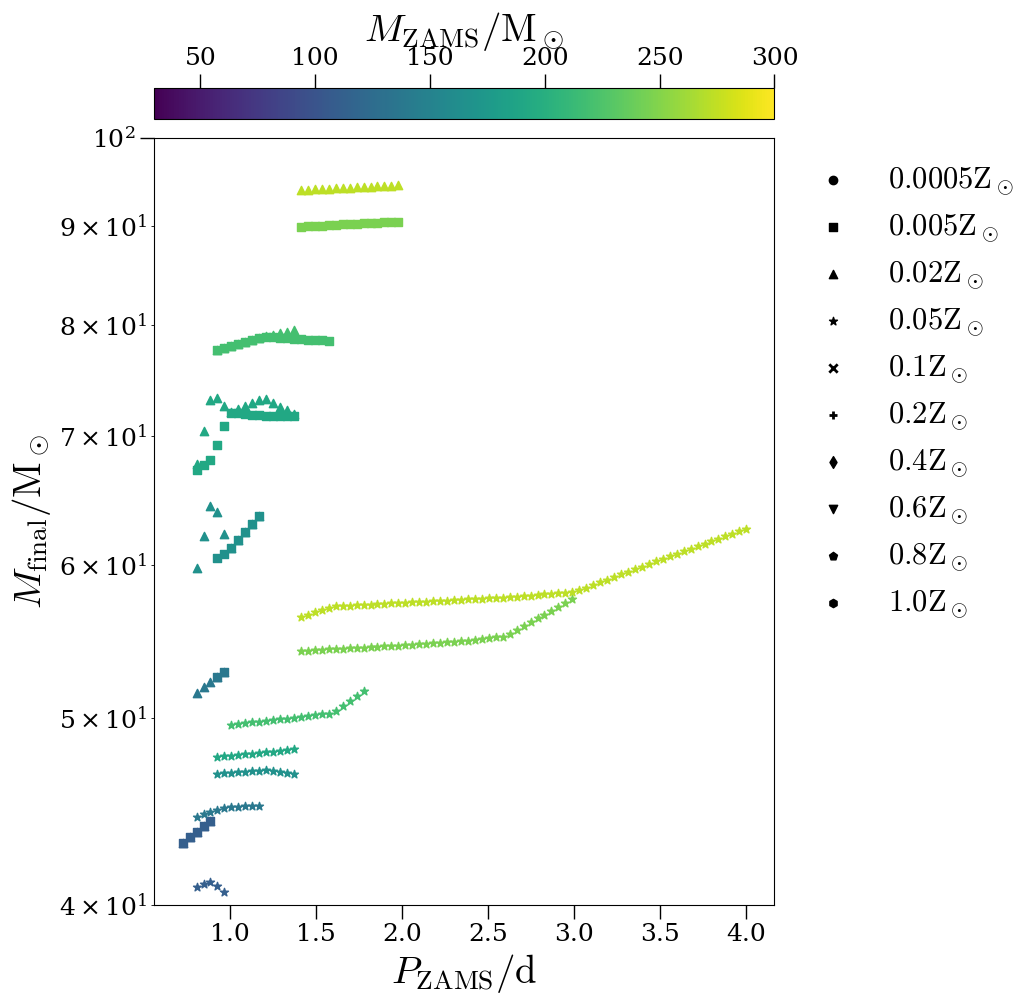

In [97]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z not in ['0.05', '0.02', '0.005']:
        continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z])
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

ax.set_ylim(40, 100)

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

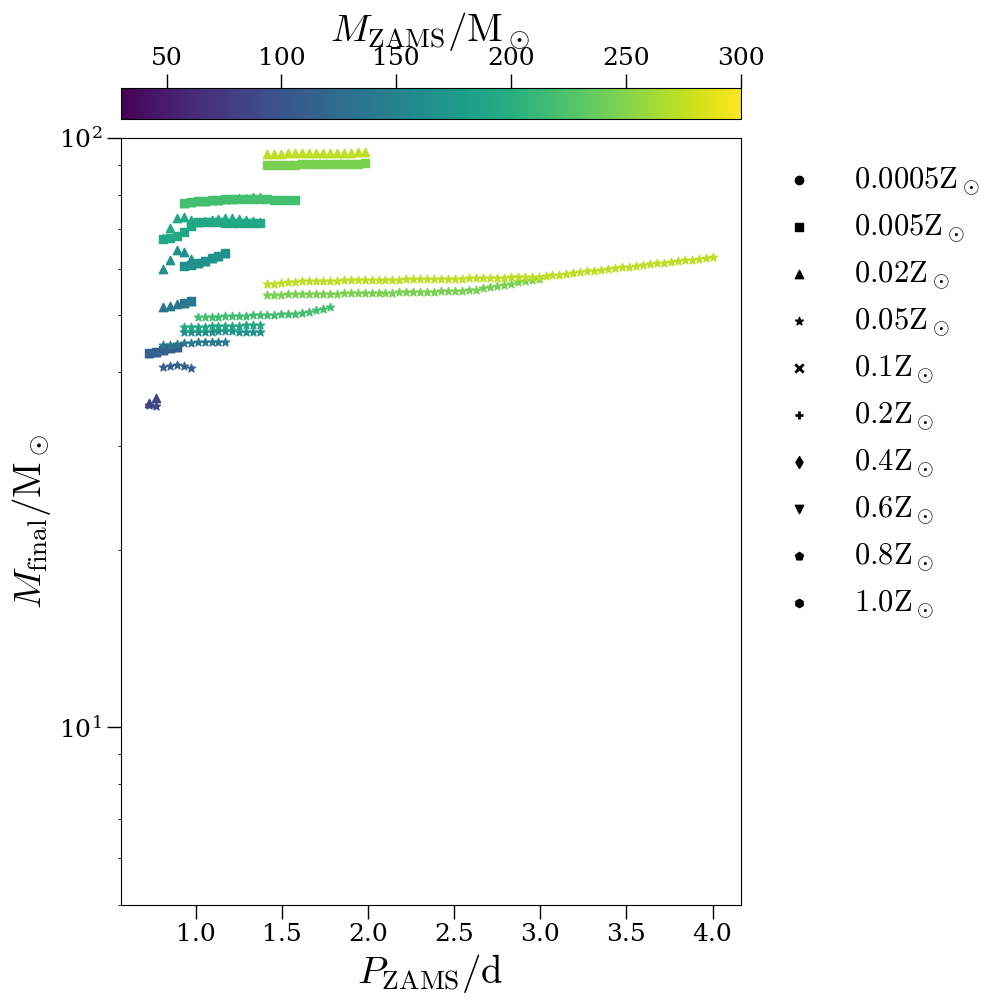

In [103]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z not in ['0.05', '0.02', '0.005']:
        continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z])
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

ax.set_ylim(5, 100)

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

In [98]:
from astropy.cosmology import WMAP9 as cosmo
th = cosmo.age(0).to(u.yr).value

Text(4, 35, '$35\\,\\mathrm{M}_\\odot$')

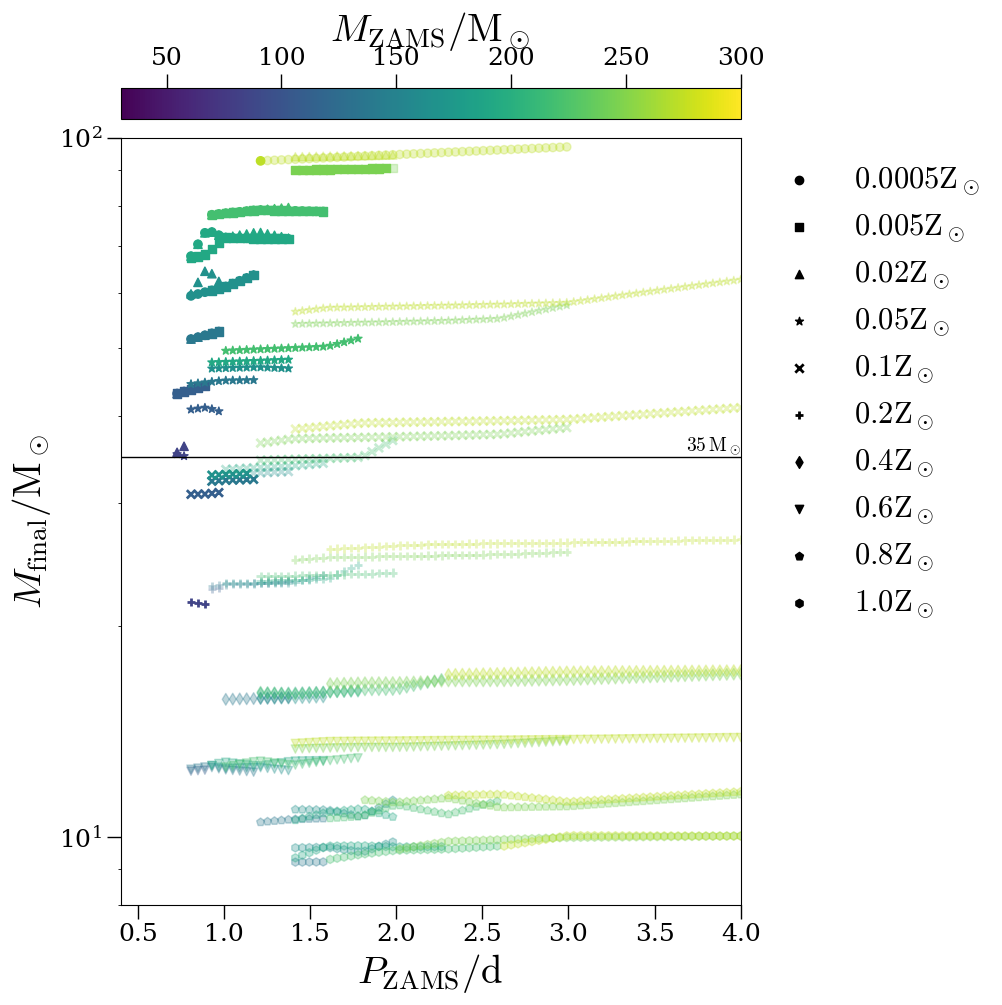

In [99]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    #if z not in ['0.6', '0.8', '1.0']:
        #continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        td = l2_mzams_tdelay_interpolator_dict[z][m](np.linspace(0, 4, 100))
        alpha = []
        for t in td:
            if t > th:
                alpha.append(0.3)
            else:
                alpha.append(1)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z], alpha=alpha)
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

ax.set_xlim(0.4, 4)
ax.set_ylim(8, 100)
ax.hlines(35, 0.4, 4, color='k', ls='-', lw=1)
ax.text(4, 35, '$35\\,\\mathrm{M}_\\odot$', color='k', fontsize=14, ha='right', va='bottom')

Text(4, 35, '$35\\,\\mathrm{M}_\\odot$')

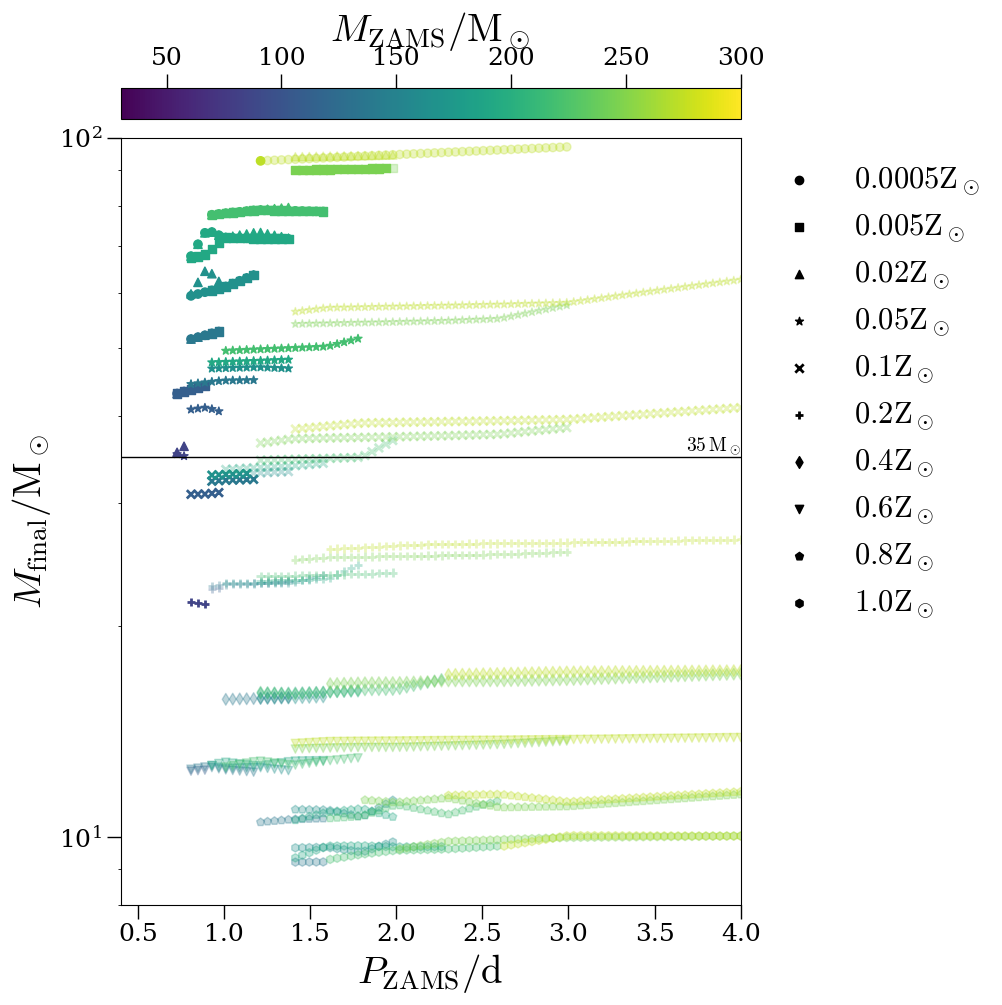

In [100]:
fig, ax = plt.subplots(figsize=(8, 12))


for z in l2_mzams_mcore_interpolator_dict.keys():
    #if z not in ['0.6', '0.8', '1.0']:
        #continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        td = l2_mzams_tdelay_interpolator_dict[z][m](np.linspace(0, 4, 100))
        alpha = []
        for t in td:
            if t > th:
                alpha.append(0.3)
            else:
                alpha.append(1)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z], alpha=alpha)
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

ax.set_xlim(0.4, 4)
ax.set_ylim(8, 100)
ax.hlines(35, 0.4, 4, color='k', ls='-', lw=1)
ax.text(4, 35, '$35\\,\\mathrm{M}_\\odot$', color='k', fontsize=14, ha='right', va='bottom')

Text(4, 35, '$35\\,\\mathrm{M}_\\odot$')

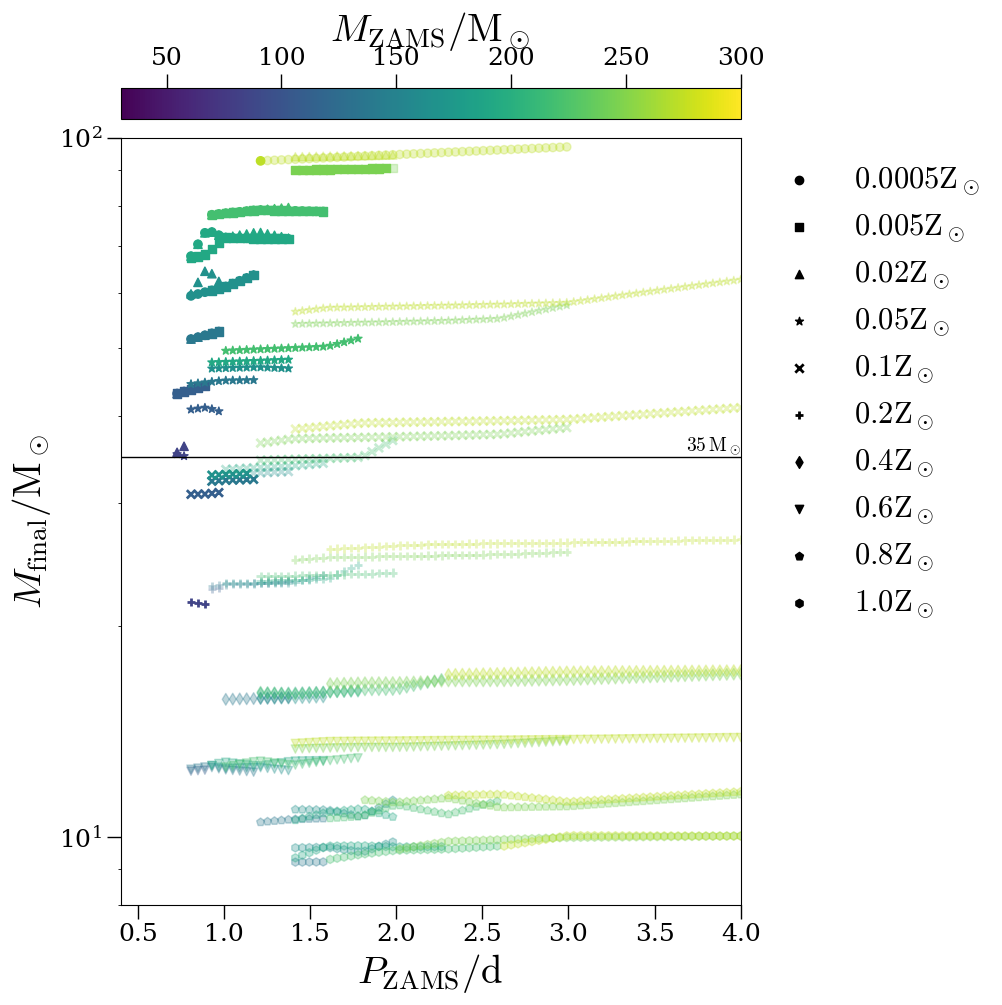

In [101]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    #if z not in ['0.6', '0.8', '1.0']:
        #continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        td = l2_mzams_tdelay_interpolator_dict[z][m](np.linspace(0, 4, 100))
        alpha = []
        for t in td:
            if t > th:
                alpha.append(0.3)
            else:
                alpha.append(1)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z], alpha=alpha)
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

ax.set_xlim(0.4, 4)
ax.set_ylim(8, 100)
ax.hlines(35, 0.4, 4, color='k', ls='-', lw=1)
ax.text(4, 35, '$35\\,\\mathrm{M}_\\odot$', color='k', fontsize=14, ha='right', va='bottom')

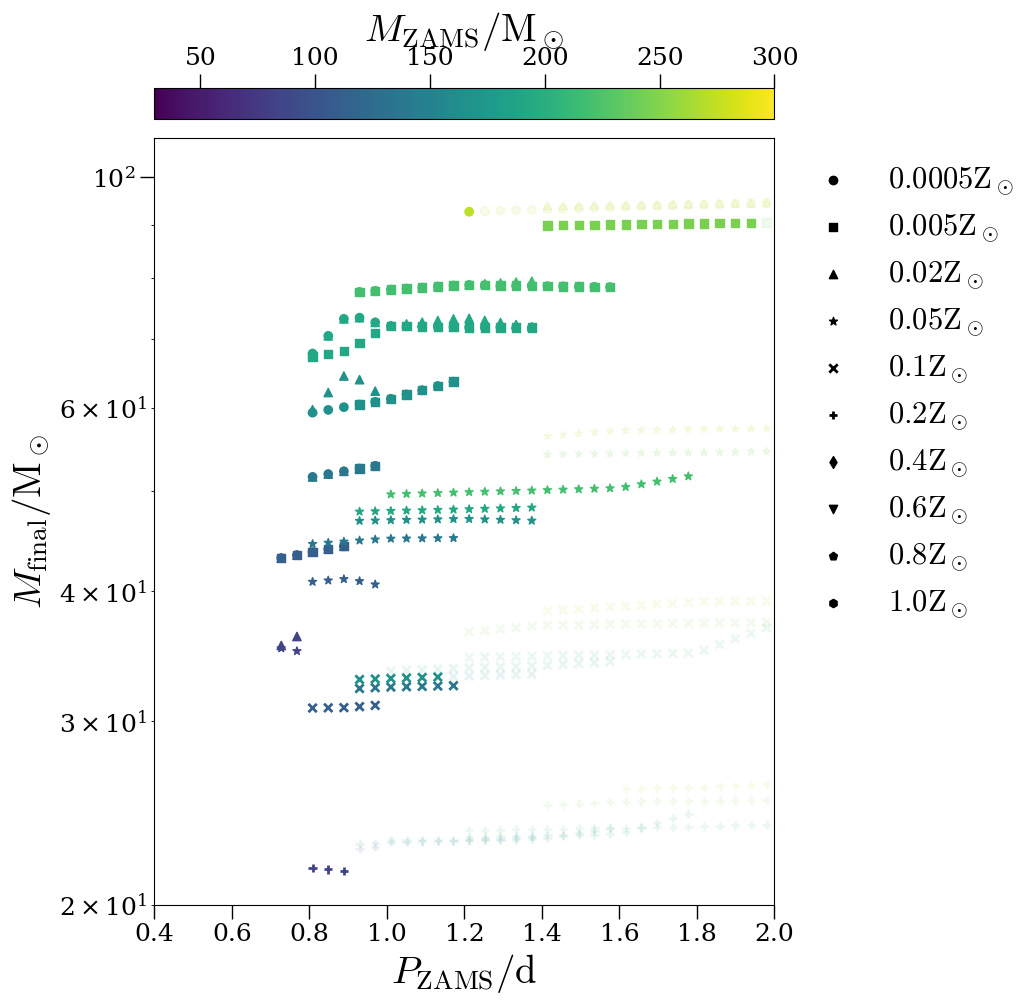

In [102]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    #if z not in ['0.6', '0.8', '1.0']:
        #continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        td = l2_mzams_tdelay_interpolator_dict[z][m](np.linspace(0, 4, 100))
        alpha = []
        for t in td:
            if t > th:
                alpha.append(0.1)
            else:
                alpha.append(1)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z], alpha=alpha)
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')
ax.set_xlim(0.4, 2)
ax.set_ylim(20)

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

Text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\\mathrm{ZAMS}$\nare available at all metallicities')

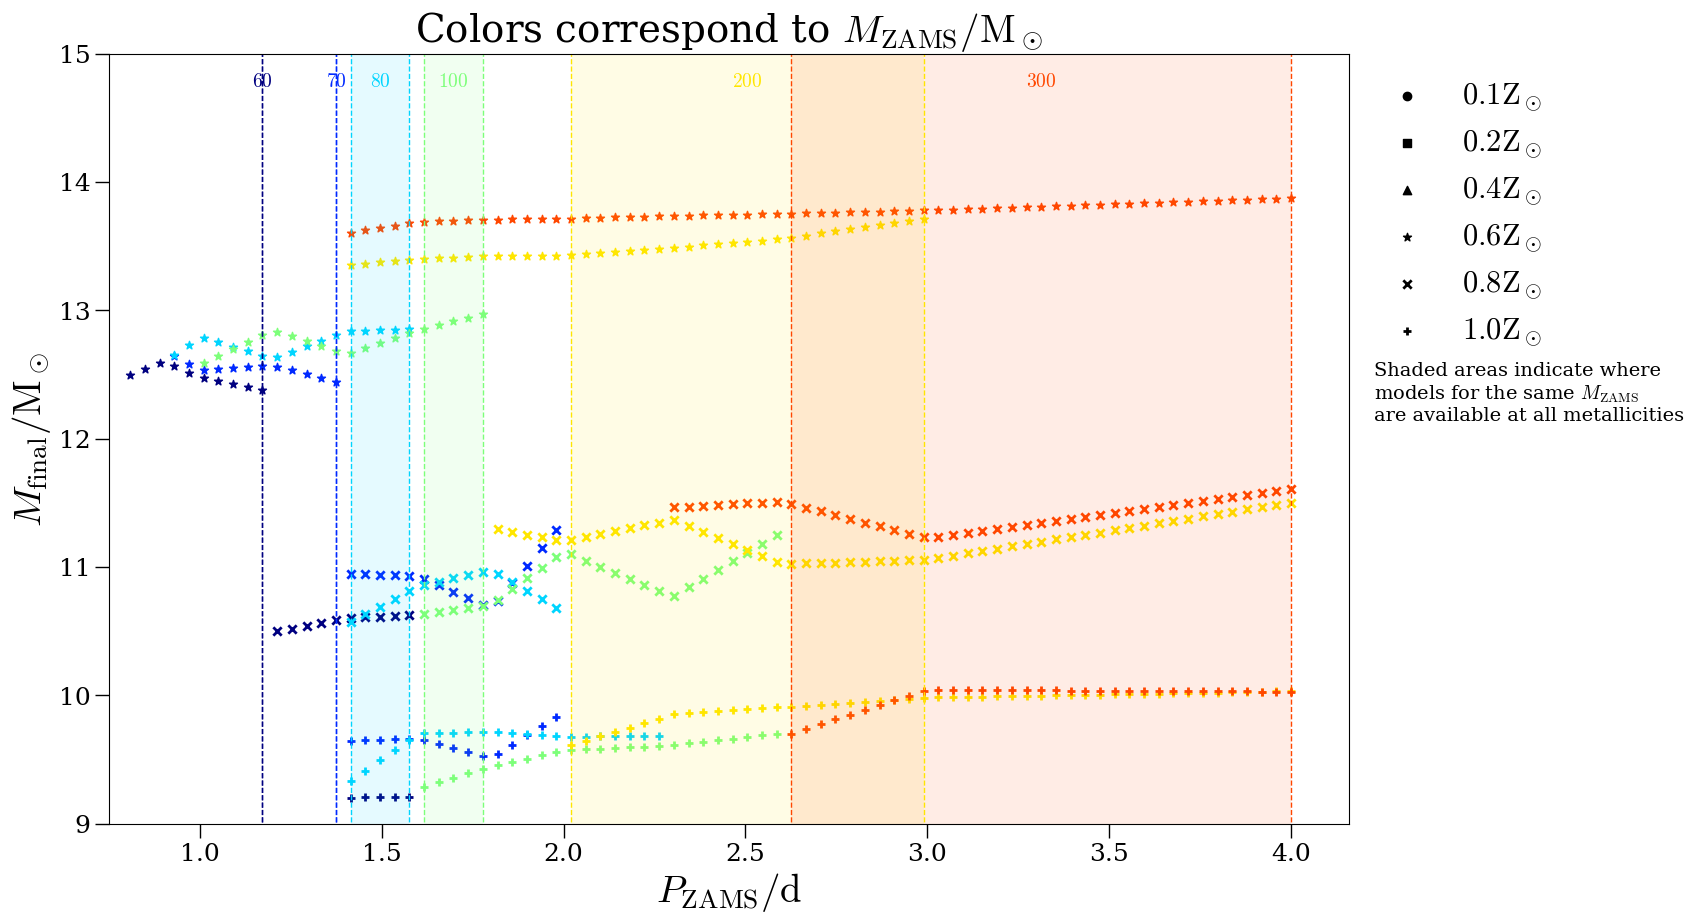

In [44]:
fig, ax = plt.subplots(figsize=(16, 10))
maxy = 15
cmap = cm.jet

met_m = {
    '0.1': 'o',
    '0.2': 's',
    '0.4': '^',
    '0.6': '*',
    '0.8': 'x',
    '1.0': '+'
}

overlap_dict = dict()

pzams_arr = np.linspace(0, 4, 100)
mkeys_to_plot = ['60.0', '70.0', '80.0', '100.0', '200.0', '300.0']

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z not in ['0.6', '0.8', '1.0']:
        continue
    for i, m in enumerate(mkeys_to_plot):
        ip = l2_mzams_mcore_interpolator_dict[z][m]
        mfinal_arr = ip(pzams_arr)
        c = cmap(i/len(mkeys_to_plot))
        ax.scatter(pzams_arr, mfinal_arr, color=c, marker=met_m[z])
        
        if m not in overlap_dict.keys():
            overlap_dict[m] = (0, len(pzams_arr)-1)
        try:
            min_p_i = np.where(~np.isnan(mfinal_arr))[0][0]
        except IndexError:
            min_p_i = 0
            max_p_i = 0
            overlap_dict[m] = (0, 0)
            
        else:
            max_p_i = np.where(~np.isnan(mfinal_arr))[0][-1]

        if min_p_i > overlap_dict[m][0]:
            overlap_dict[m] = (min(min_p_i, overlap_dict[m][1]), overlap_dict[m][1])
        if max_p_i < overlap_dict[m][1]:    
            overlap_dict[m] = (overlap_dict[m][0], max(max_p_i, overlap_dict[m][0]))
            
for i, m in enumerate(overlap_dict.keys()):
    c = cmap(i/len(overlap_dict.keys()))
    min_p_i, max_p_i = overlap_dict[m]

    ax.vlines(pzams_arr[min_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.vlines(pzams_arr[max_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.axvspan(pzams_arr[min_p_i], pzams_arr[max_p_i], color=c, alpha=0.1, lw=0)   
    ax.text(
        (pzams_arr[min_p_i]+pzams_arr[max_p_i])/2,
        maxy*0.99,
        f'${float(m):.0f}$',
        color=c,
        transform=ax.transData,
        ha='center',
        va='top',
        fontsize=14
    )


ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
#ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

ax.set_ylim(9, 15)
ax.set_xlim(0.75)

ax.set_title('Colors correspond to $M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\mathrm{ZAMS}$\nare available at all metallicities', ha='left', va='top', transform=ax.transAxes, fontsize=14)

Text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\\mathrm{ZAMS}$\nare available at all metallicities')

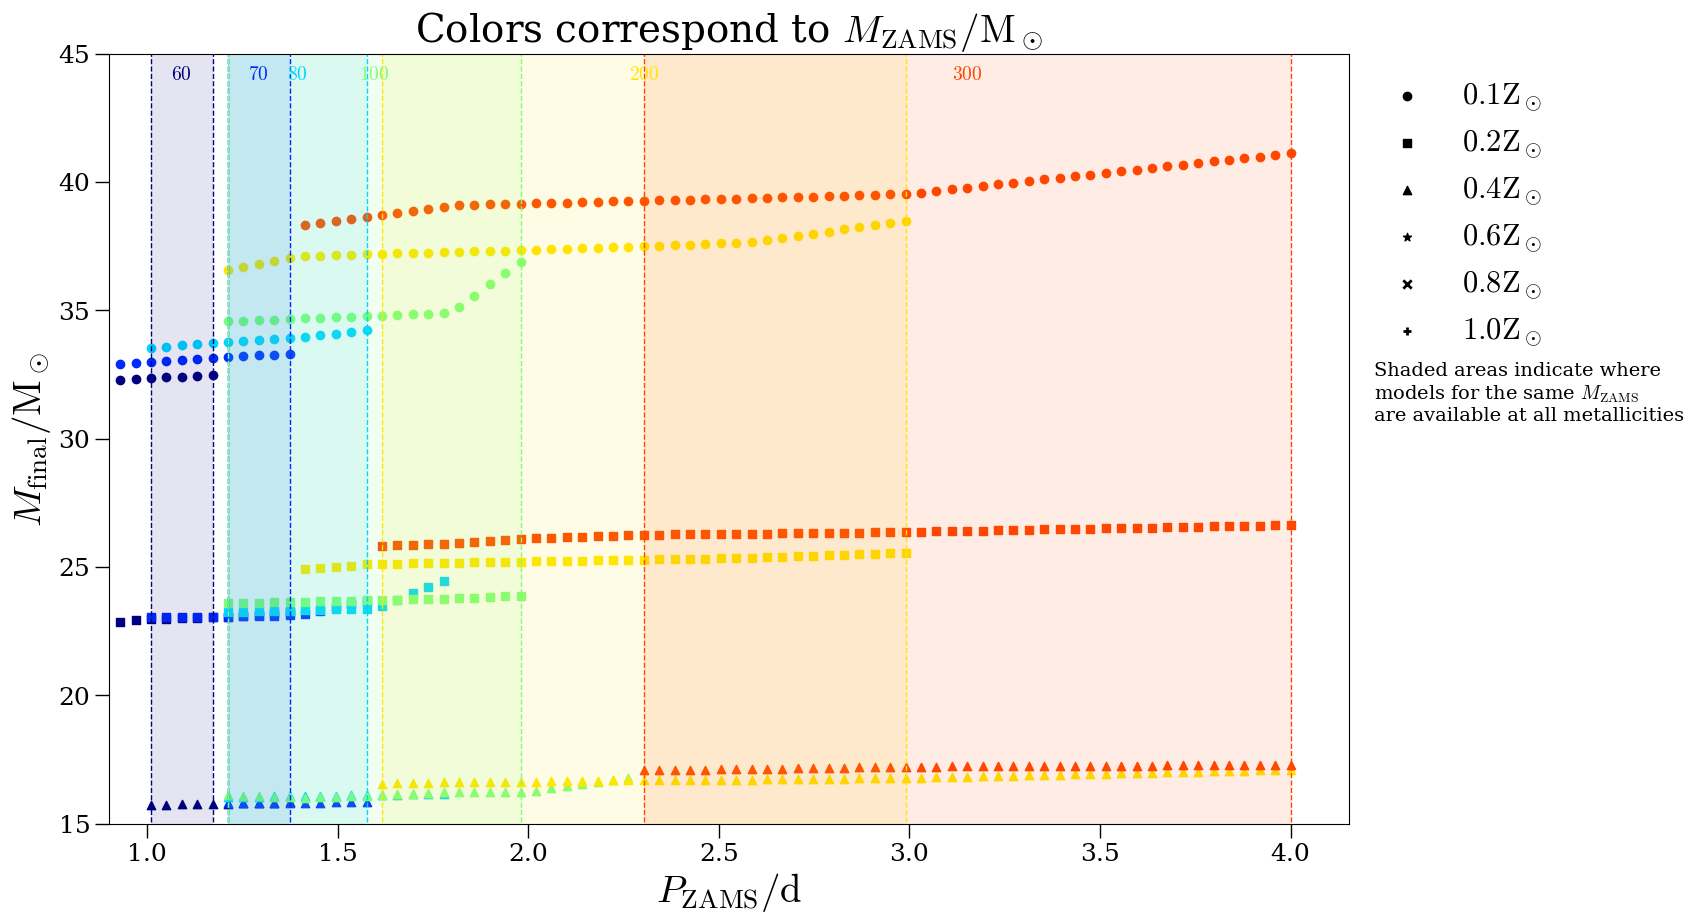

In [45]:
fig, ax = plt.subplots(figsize=(16, 10))
maxy = 45
cmap = cm.jet

met_m = {
    '0.1': 'o',
    '0.2': 's',
    '0.4': '^',
    '0.6': '*',
    '0.8': 'x',
    '1.0': '+'
}

overlap_dict = dict()

pzams_arr = np.linspace(0, 4, 100)
mkeys_to_plot = ['60.0', '70.0', '80.0', '100.0', '200.0', '300.0']

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z in ['0.0005', '0.005', '0.02', '0.05', '0.6', '0.8', '1.0']:
        continue
    for i, m in enumerate(mkeys_to_plot):
        ip = l2_mzams_mcore_interpolator_dict[z][m]
        mfinal_arr = ip(pzams_arr)
        c = cmap(i/len(mkeys_to_plot))
        ax.scatter(pzams_arr, mfinal_arr, color=c, marker=met_m[z])
        
        if m not in overlap_dict.keys():
            overlap_dict[m] = (0, len(pzams_arr)-1)
        try:
            min_p_i = np.where(~np.isnan(mfinal_arr))[0][0]
        except IndexError:
            min_p_i = 0
            max_p_i = 0
            overlap_dict[m] = (0, 0)
            
        else:
            max_p_i = np.where(~np.isnan(mfinal_arr))[0][-1]

        if min_p_i > overlap_dict[m][0]:
            overlap_dict[m] = (min(min_p_i, overlap_dict[m][1]), overlap_dict[m][1])
        if max_p_i < overlap_dict[m][1]:    
            overlap_dict[m] = (overlap_dict[m][0], max(max_p_i, overlap_dict[m][0]))
            
for i, m in enumerate(overlap_dict.keys()):
    c = cmap(i/len(overlap_dict.keys()))
    min_p_i, max_p_i = overlap_dict[m]

    ax.vlines(pzams_arr[min_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.vlines(pzams_arr[max_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.axvspan(pzams_arr[min_p_i], pzams_arr[max_p_i], color=c, alpha=0.1, lw=0)   
    ax.text(
        (pzams_arr[min_p_i]+pzams_arr[max_p_i])/2,
        maxy*0.99,
        f'${float(m):.0f}$',
        color=c,
        transform=ax.transData,
        ha='center',
        va='top',
        fontsize=14
    )


ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
#ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

ax.set_ylim(15, maxy)
ax.set_xlim(0.9)

ax.set_title('Colors correspond to $M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\mathrm{ZAMS}$\nare available at all metallicities', ha='left', va='top', transform=ax.transAxes, fontsize=14)

Text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\\mathrm{ZAMS}$\nare available at all metallicities')

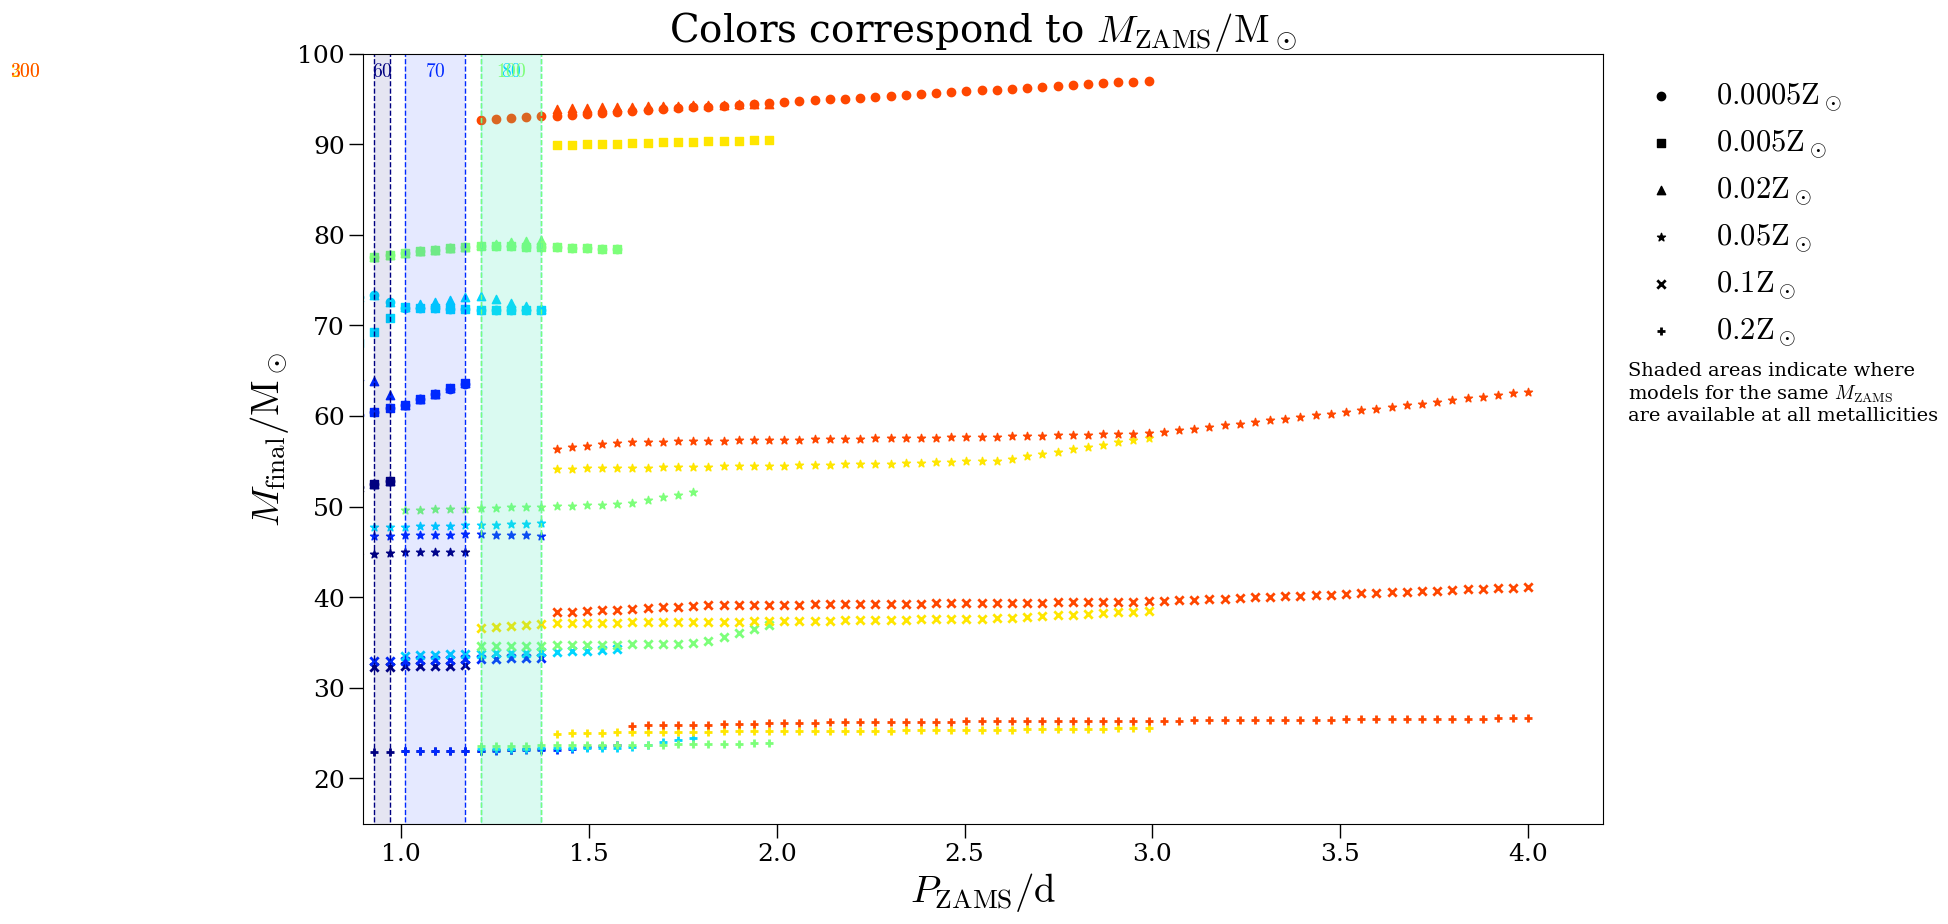

In [46]:
fig, ax = plt.subplots(figsize=(16, 10))
maxy = 100
cmap = cm.jet

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+'
}

overlap_dict = dict()

pzams_arr = np.linspace(0, 4, 100)
mkeys_to_plot = ['60.0', '70.0', '80.0', '100.0', '200.0', '300.0']

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z not in ['0.0005', '0.005', '0.02', '0.05', '0.1', '0.2']:
        continue
    for i, m in enumerate(mkeys_to_plot):
        ip = l2_mzams_mcore_interpolator_dict[z][m]
        mfinal_arr = ip(pzams_arr)
        c = cmap(i/len(mkeys_to_plot))
        ax.scatter(pzams_arr, mfinal_arr, color=c, marker=met_m[z])
        
        if m not in overlap_dict.keys():
            overlap_dict[m] = (0, len(pzams_arr)-1)
        try:
            min_p_i = np.where(~np.isnan(mfinal_arr))[0][0]
        except IndexError:
            min_p_i = 0
            max_p_i = 0
            overlap_dict[m] = (0, 0)
            
        else:
            max_p_i = np.where(~np.isnan(mfinal_arr))[0][-1]

        if min_p_i > overlap_dict[m][0]:
            overlap_dict[m] = (min(min_p_i, overlap_dict[m][1]), overlap_dict[m][1])
        if max_p_i < overlap_dict[m][1]:    
            overlap_dict[m] = (overlap_dict[m][0], max(max_p_i, overlap_dict[m][0]))
            
for i, m in enumerate(overlap_dict.keys()):
    c = cmap(i/len(overlap_dict.keys()))
    min_p_i, max_p_i = overlap_dict[m]

    ax.vlines(pzams_arr[min_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.vlines(pzams_arr[max_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.axvspan(pzams_arr[min_p_i], pzams_arr[max_p_i], color=c, alpha=0.1, lw=0)   
    ax.text(
        (pzams_arr[min_p_i]+pzams_arr[max_p_i])/2,
        maxy*0.99,
        f'${float(m):.0f}$',
        color=c,
        transform=ax.transData,
        ha='center',
        va='top',
        fontsize=14
    )


ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
#ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

ax.set_ylim(15, maxy)
ax.set_xlim(0.9)

ax.set_title('Colors correspond to $M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\mathrm{ZAMS}$\nare available at all metallicities', ha='left', va='top', transform=ax.transAxes, fontsize=14)

In [47]:
test_core_dict = final_core_prop_array_dict['0.1']
guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts['0.1'])

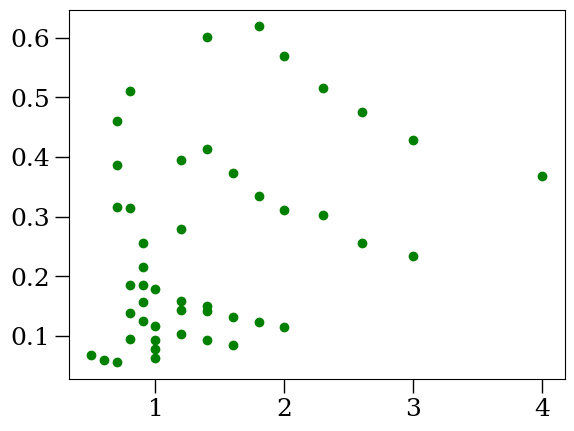

In [48]:
fig, ax = plt.subplots()

for i_p, pkey in enumerate(guide_p_str):
    p = guide_p_float[i_p]
    pzams_s = p * u.d.to(u.s)
    
    w_arr = test_core_dict[i_p, :, 2]
    ische_arr = test_core_dict[i_p, :, 9]
    
    pspin_arr = 2*np.pi/w_arr
    
    for i_pspin, pspin in enumerate(pspin_arr):
        if ische_arr[i_pspin]:
            ax.scatter(p, pspin/pzams_s, c='g')      
    

In [49]:
def draw_mass_sample(
    set_cores,
    set_rzams,
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=None,
    max_mfinal=None,
    mfinal_bin_width=0.1
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([set_rzams(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))
    sample_xcores = np.zeros(int(res/100))
    sample_delay_times = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores, sample_xcores, sample_delay_times]).T
    zams_l2of_sample = set_cores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]
    
    if min_mfinal is None:
        min_mfinal = min(mass_draw)
    if max_mfinal is None:
        max_mfinal = max(mass_draw)

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [50]:
def draw_mass_sample_freemet(
    set_cores,
    set_rzams,
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_zdivzsun=0.1,
    max_zdivzsun=1.0,
    min_mfinal=None,
    max_mfinal=None,
    mfinal_bin_width=0.1
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))
    
    sample_zs = np.linspace(np.log10(min_zdivzsun), np.log10(max_zdivzsun), res)
    sample_probs = np.ones(res)/res
    sample_zs = 10.**np.random.choice(sample_zs, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([set_rzams(z, m, p) for z, m, p in zip(sample_zs, sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))
    sample_xcores = np.zeros(int(res/100))
    sample_delay_times = np.zeros(int(res/100))

    sample_ = np.array([sample_zs, sample_masses, sample_periods, sample_zams_rs, sample_mcores, sample_xcores, sample_delay_times]).T
    zams_l2of_sample = set_cores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 4]
    mass_draw = mass_draw[~np.isnan(mass_draw)]
    
    if min_mfinal is None:
        min_mfinal = min(mass_draw)
    if max_mfinal is None:
        max_mfinal = max(mass_draw)

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

Next we generate our interpolated populations at all the available metallicites.

In [51]:
def get_z_guides(model_dicts):
    guide_z_str = []
    for z in model_dicts.keys():
        guide_z_str.append(z)
    guide_z_str = np.unique(guide_z_str)
    guide_z_float = np.float64(guide_z_str)
    guide_z_str = guide_z_str[np.argsort(guide_z_float)]
    guide_z_float = np.sort(guide_z_float)
    return guide_z_str, guide_z_float
guide_z_str, guide_z_float = get_z_guides(final_core_prop_array_dict)

In [52]:
def get_fname(id, size):
    return f'{int(100*float(id)):03d}Zdiv100Zsun_enhanced_w_{size}_pop2.npy'

In [53]:
guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts_01zsun)
set_cores = get_set_cores_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float)
set_rzams = get_set_rzams_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float)

In [54]:
res = int(1e6)
min_m = 10
max_m = 300
min_p = 0.2
max_p = 4.
min_zdivzsun = 0.0005
max_zdivzsun = 1.0
min_mfinal = None
max_mfinal = None
mfinal_bin_width = 0.1

In [87]:
sample, mode = draw_mass_sample_freemet(
    set_cores,
    set_rzams,
    res=res,
    min_m=min_m,
    max_m=max_m,
    min_p=min_p,
    max_p=max_p,
    min_zdivzsun=min_zdivzsun,
    max_zdivzsun=max_zdivzsun,
    min_mfinal=min_mfinal,
    max_mfinal=max_mfinal,
    mfinal_bin_width=mfinal_bin_width
)

msample = sample[~np.isnan(sample[:, 3])]

np.save(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w.npy', sample)
np.save(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w_mergers_only.npy', msample)

/tmp/ipykernel_2086009/2191712151.py:56: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated = series.interpolate(method='spline', order=2)
/tmp/ipykernel_2086009/2191712151.py:89: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated = series.interpolate(method='spline', order=2)
/tmp/ipykernel_2086009/3262690221.py:60: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated = series.interpolate(method='spline', order=2)
/tmp/ipykernel_2086009/3262690221.py:93: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before inter

KeyboardInterrupt: 

In [57]:
sample = np.load(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w.npy')
msample = np.load(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w_mergers_only.npy')

In [58]:
sample.shape, msample.shape

((10000, 7), (51, 7))

In [59]:
import pandas as pd
import seaborn as sns

In [60]:
df = pd.DataFrame(
    sample, 
    columns=[
        'z_zsun',
        'm_zams_msun',            
        'p_zams_d',
        'r_zams_rsun',
        'm_final_msun',
        'x_final',
        'log_td_yr'
        ]
    )

In [73]:
df = df[~np.isnan(df['m_final_msun'])]

In [61]:
df.log_td_yr = np.log10(df.log_td_yr)

In [62]:
def set_met_range(row):
    boundaries = [0.0005, 0.005, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    for i, boundary in enumerate(boundaries):
        if row.z_zsun <= boundary:
            return f'{boundaries[i-1]}<z_zsun<={boundary}'
    return f'z_zsun>{boundary}'

In [63]:
met_ranges = {
    0: '<Zsun/1000',
    1: 'Zsun/1000<Z<Zsun/100',
    2: 'Zsun/100<Z<Zsun/50',
    3: 'Zsun/50<Z<Zsun/20',
    4: 'Zsun/20<Z<Zsun/10',
    5: 'Zsun/10<Z<Zsun/5',
    6: 'Zsun/5<Z<Zsun/2',
    7: '>Zsun/2'   
}

met_ranges = {
    0: r'$<\mathrm{Z}_\odot/1000$',
    1: r'$\mathrm{Z}_\odot/1000<Z<\mathrm{Z}_\odot/100$',
    2: r'$\mathrm{Z}_\odot/100<Z<\mathrm{Z}_\odot/50$',
    3: r'$\mathrm{Z}_\odot/50<Z<\mathrm{Z}_\odot/20$',
    4: r'$\mathrm{Z}_\odot/20<Z<\mathrm{Z}_\odot/10$',
    5: r'$\mathrm{Z}_\odot/10<Z<\mathrm{Z}_\odot/5$',
    6: r'$\mathrm{Z}_\odot/5<Z<\mathrm{Z}_\odot/2$',
    7: r'$>\mathrm{Z}_\odot/2$'
}

met_bounds = [1/1000, 1/100, 1/50, 1/20, 1/10, 1/5, 1/2]

def set_met_range(row):
    for i, boundary in enumerate(met_bounds):
        if row.z_zsun <= boundary:
            return met_ranges[i]
    return met_ranges[7]

df['Metallicity range'] = df.apply(set_met_range, axis=1)
df['Metallicity range'] = df['Metallicity range'].astype('category')

In [64]:
import seaborn as sns

Text(0.5, 0, '$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

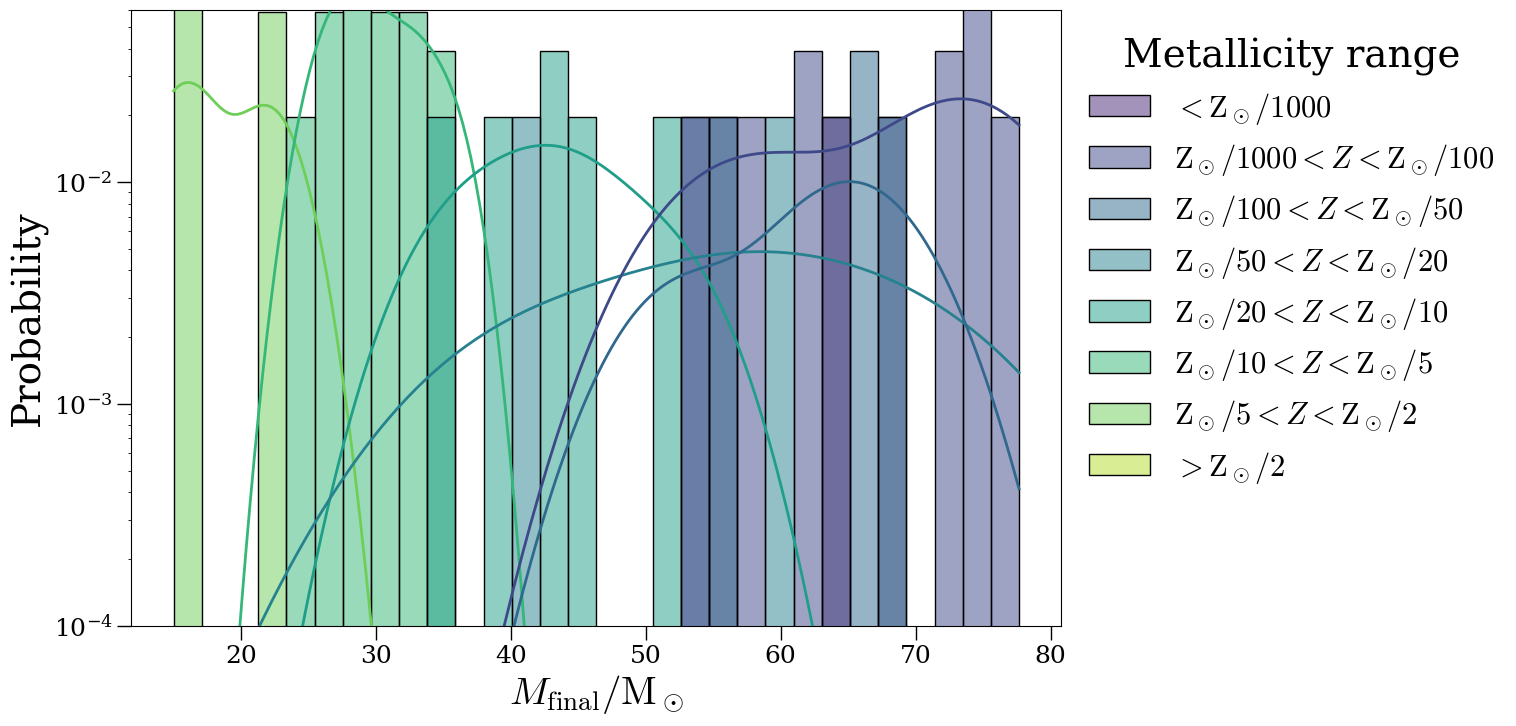

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(df, x='m_final_msun', hue='Metallicity range', stat='probability', bins=30, alpha=0.5, ax=ax,
             hue_order=list(met_ranges.values()), palette='viridis', kde=True)
ax.set_yscale('log')
ax.set_ylim(1e-4, 6e-2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel(r'$M_\mathrm{final}/\mathrm{M}_\odot$')

Text(0.5, 0, '$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

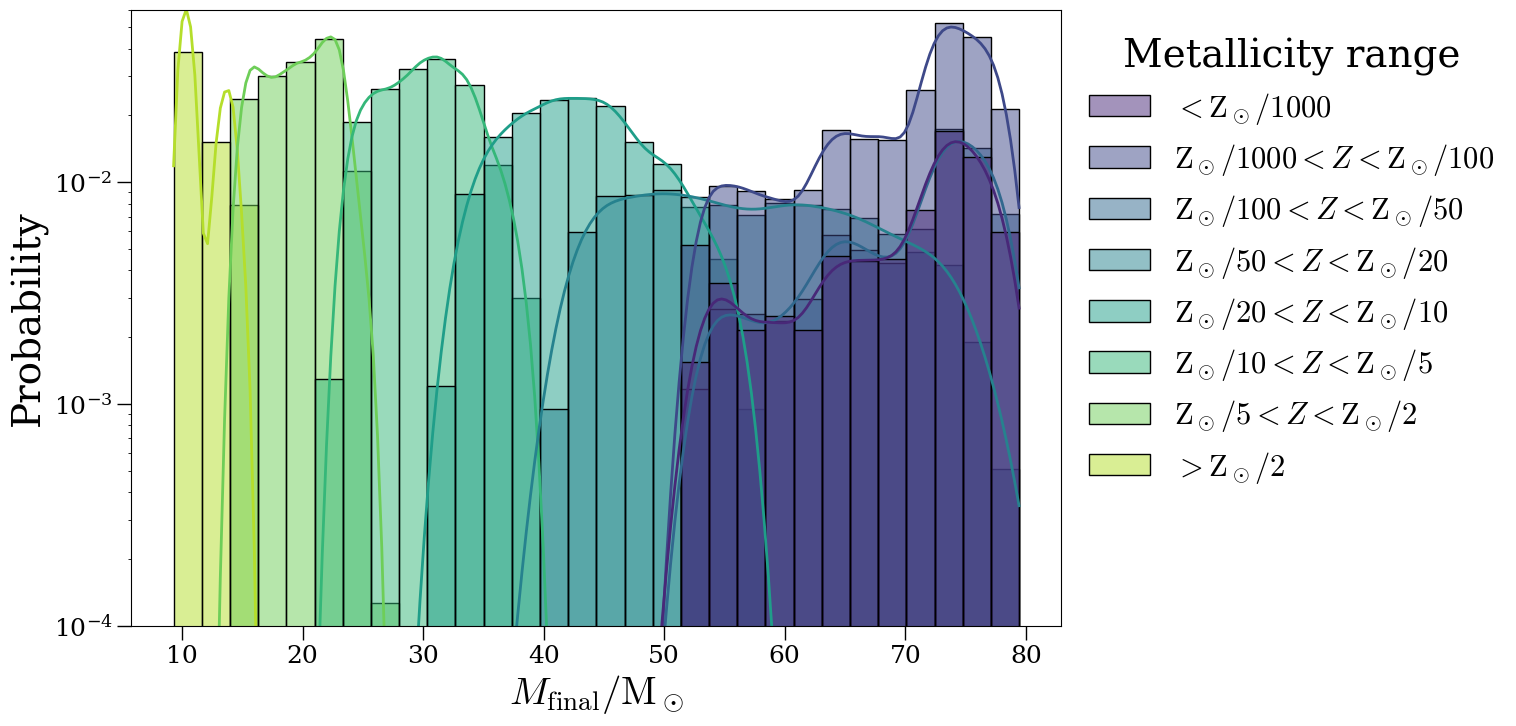

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(df, x='m_final_msun', hue='Metallicity range', stat='probability', bins=30, alpha=0.5, ax=ax,
             hue_order=list(met_ranges.values()), palette='viridis', kde=True)
ax.set_yscale('log')
ax.set_ylim(1e-4, 6e-2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel(r'$M_\mathrm{final}/\mathrm{M}_\odot$')

Text(0.5, 0, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

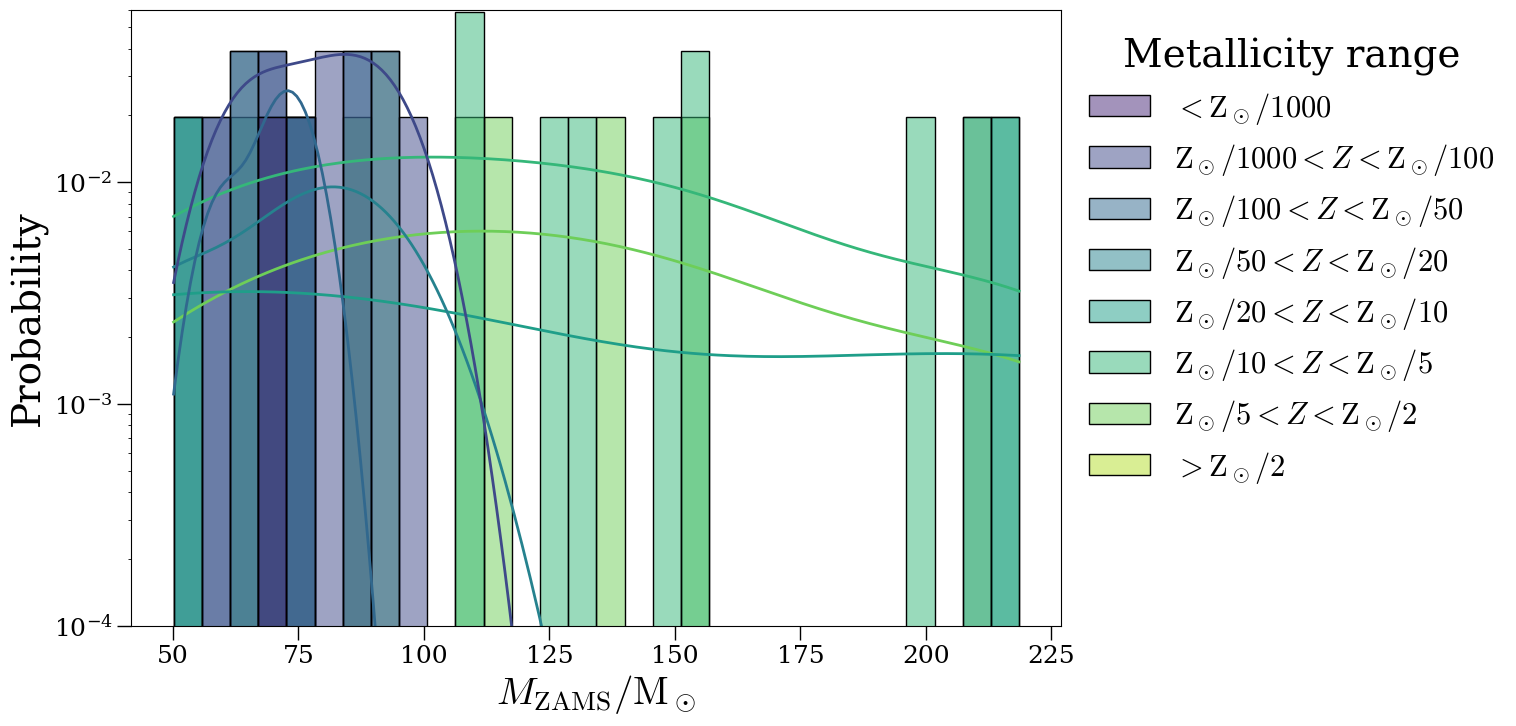

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(df, x='m_zams_msun', hue='Metallicity range', stat='probability', bins=30, alpha=0.5, ax=ax,
             hue_order=list(met_ranges.values()), palette='viridis', kde=True)
ax.set_yscale('log')
ax.set_ylim(1e-4, 6e-2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel(r'$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

In [56]:
df['Metallicity range'].unique()

['$\mathrm{Z}_\odot/1000<Z<\mathrm{Z}_\odot/100$', '$\mathrm{Z}_\odot/5<Z<\mathrm{Z}_\odot/2$', '$\mathrm{Z}_\odot/100<Z<\mathrm{Z}_\odot/50$', '$\mathrm{Z}_\odot/10<Z<\mathrm{Z}_\odot/5$', '$\mathrm{Z}_\odot/20<Z<\mathrm{Z}_\odot/10$', '$\mathrm{Z}_\odot/50<Z<\mathrm{Z}_\odot/20$', '$<\mathrm{Z}_\odot/1000$', '$>\mathrm{Z}_\odot/2$']
Categories (8, object): ['$<\mathrm{Z}_\odot/1000$', '$>\mathrm{Z}_\odot/2$', '$\mathrm{Z}_\odot/1000<Z<\mathrm{Z}_\odot/100$', '$\mathrm{Z}_\odot/100<Z<\mathrm{Z}_\odot/50$', '$\mathrm{Z}_\odot/10<Z<\mathrm{Z}_\odot/5$', '$\mathrm{Z}_\odot/20<Z<\mathrm{Z}_\odot/10$', '$\mathrm{Z}_\odot/50<Z<\mathrm{Z}_\odot/20$', '$\mathrm{Z}_\odot/5<Z<\mathrm{Z}_\odot/2$']

In [67]:
from astropy.cosmology import WMAP9 as cosmo
th = cosmo.age(0).to(u.yr).value

In [69]:
df.m_zams_msun.min()

10.001450001450001

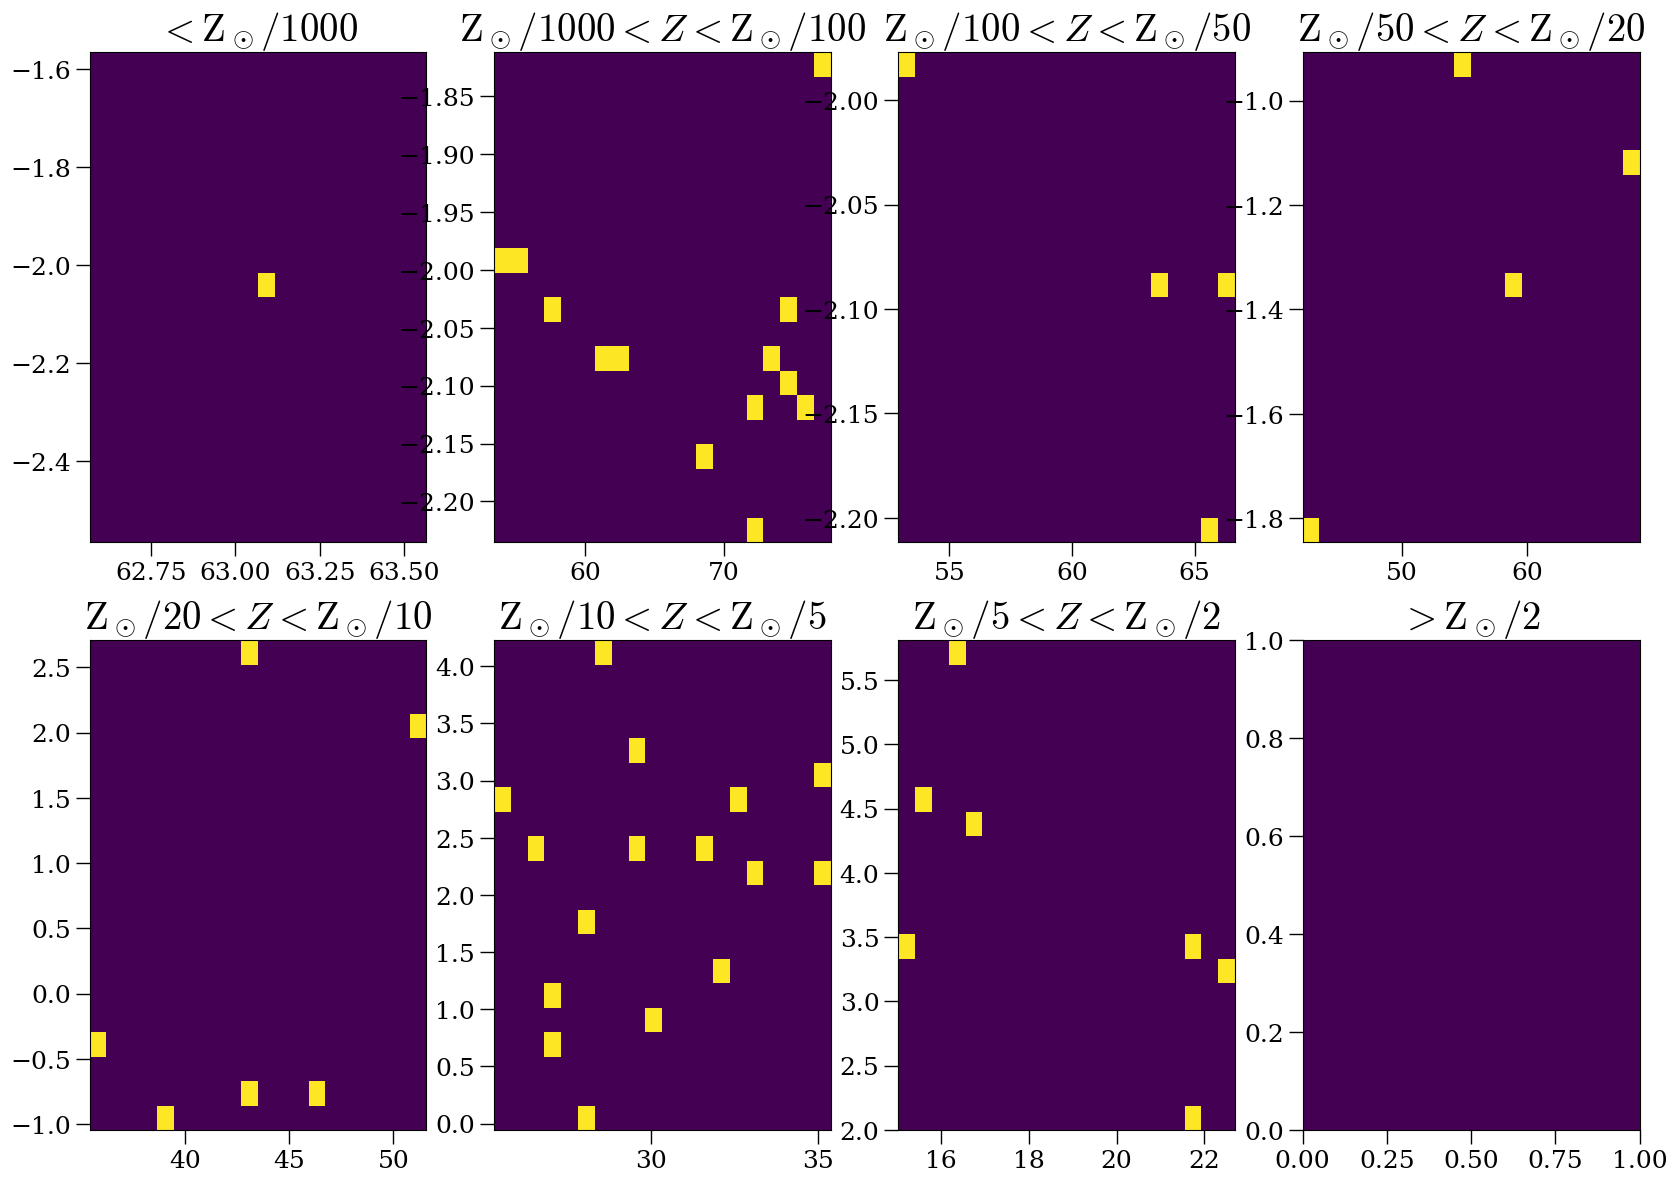

In [70]:
fig, axes = plt.subplots(2, 4, figsize=(20, 14))

for ax, cat in zip(axes.flatten(), list(met_ranges.values())):
    subdf = df[df['Metallicity range'] == cat]
    x = subdf.m_final_msun
    y = subdf.log_td_yr - np.log10(th)
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    x = x[~np.isnan(y)]	
    y = y[~np.isnan(y)]
    ax.hist2d(x, y, bins=20)
    ax.set_title(cat)
    

In [ ]:
#df = df[df.log_td_yr <= np.log10(th)]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   z_zsun             10000 non-null  float64 
 1   m_zams_msun        10000 non-null  float64 
 2   p_zams_d           10000 non-null  float64 
 3   r_zams_rsun        51 non-null     float64 
 4   m_final_msun       51 non-null     float64 
 5   x_final            51 non-null     float64 
 6   log_td_yr          51 non-null     float64 
 7   Metallicity range  10000 non-null  category
dtypes: category(1), float64(7)
memory usage: 557.1 KB


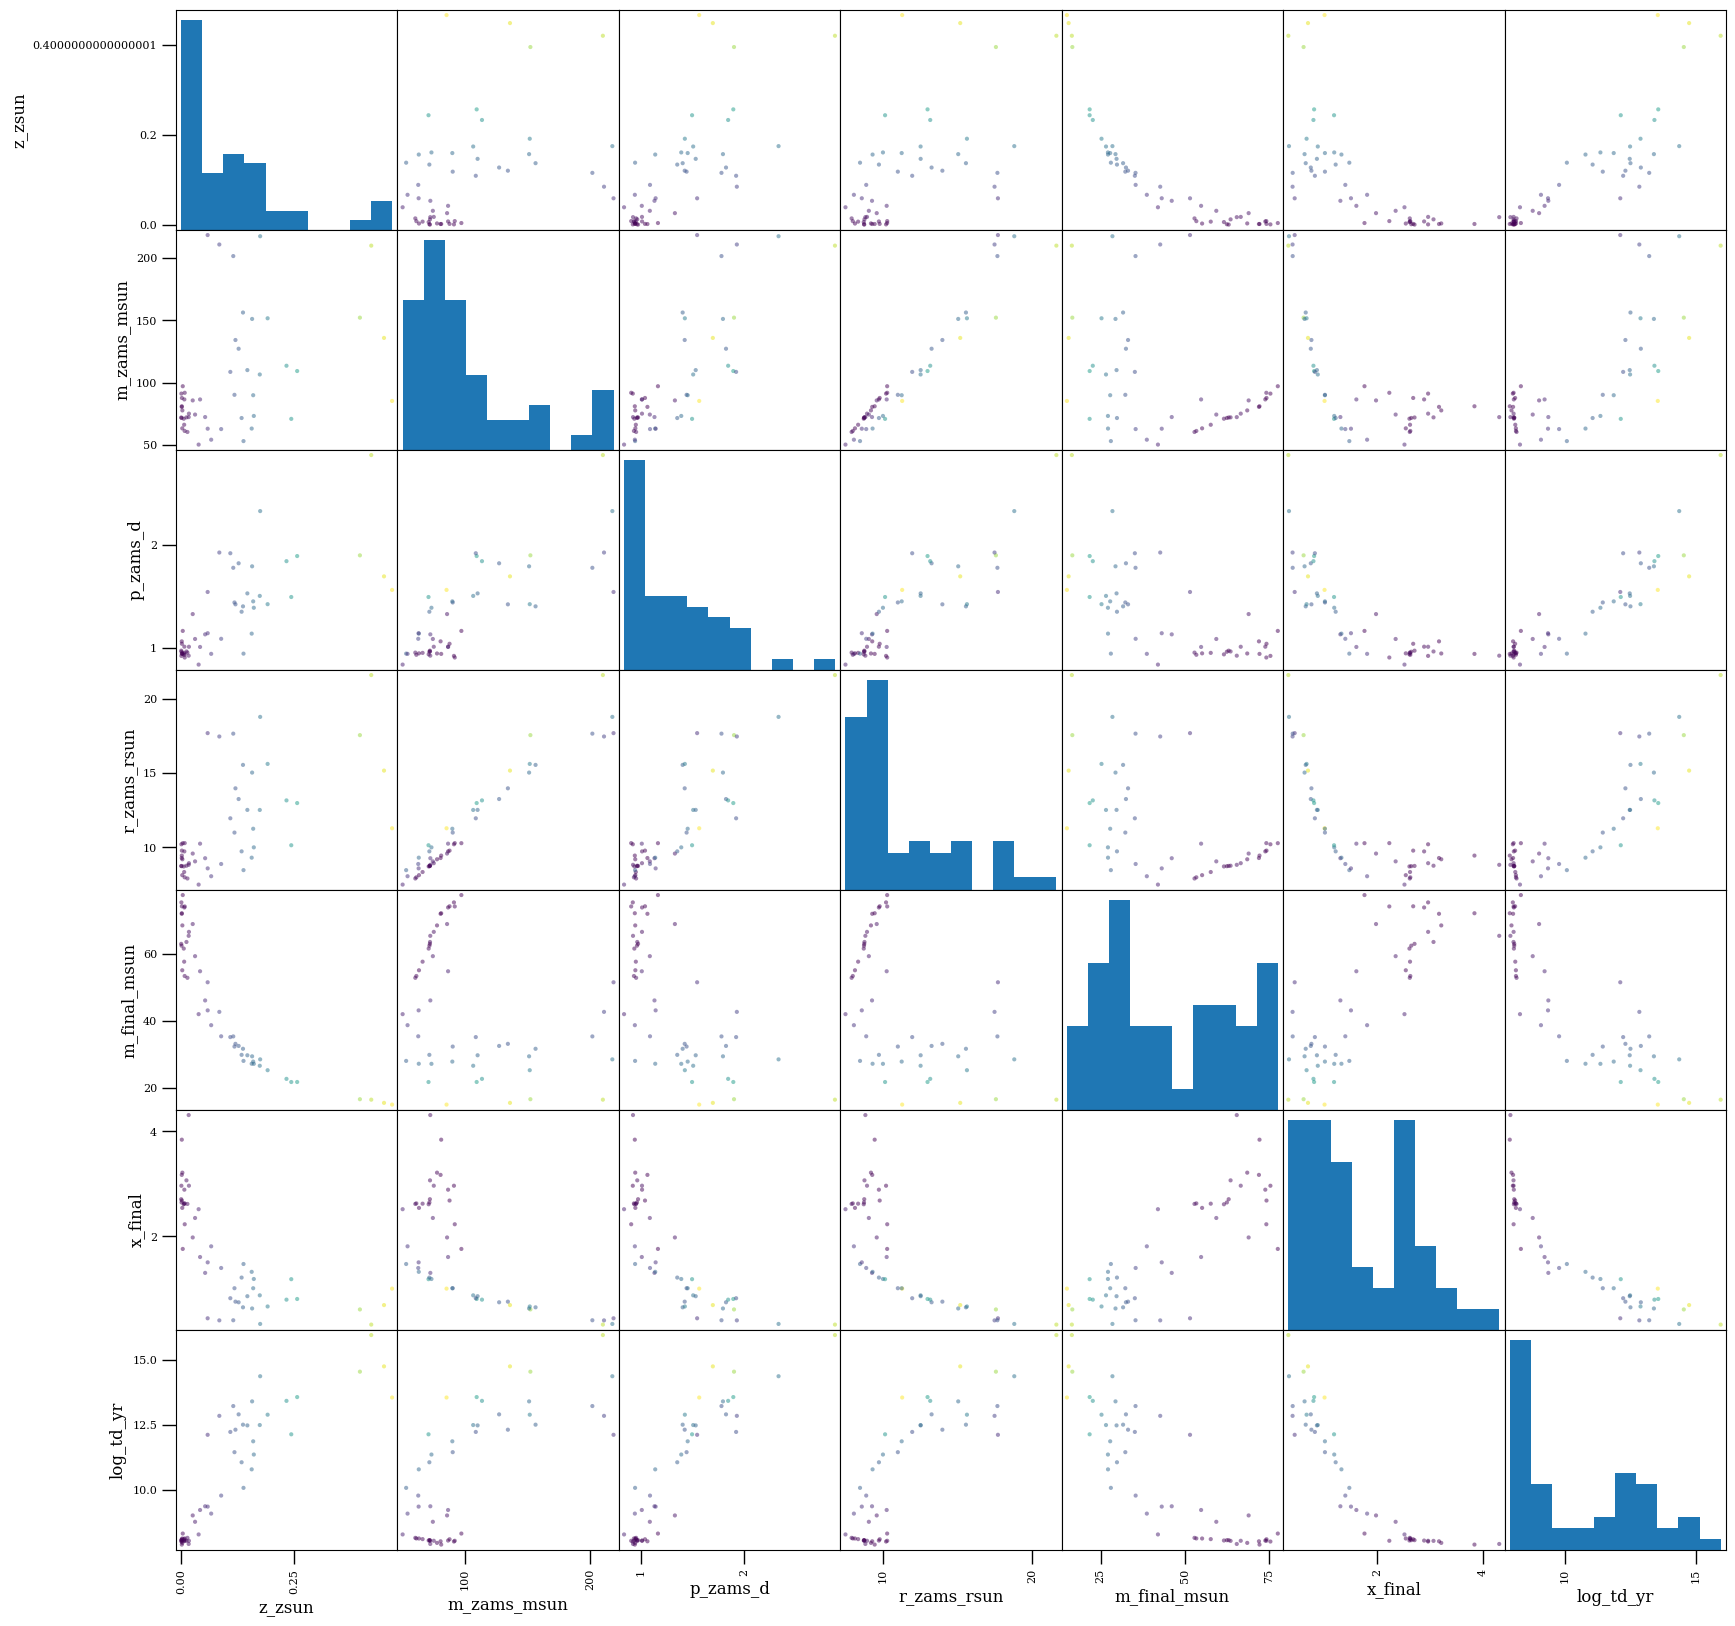

In [75]:
pd.plotting.scatter_matrix(df, c=df['z_zsun'], figsize=(20, 20))

for ax in plt.gcf().get_axes():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

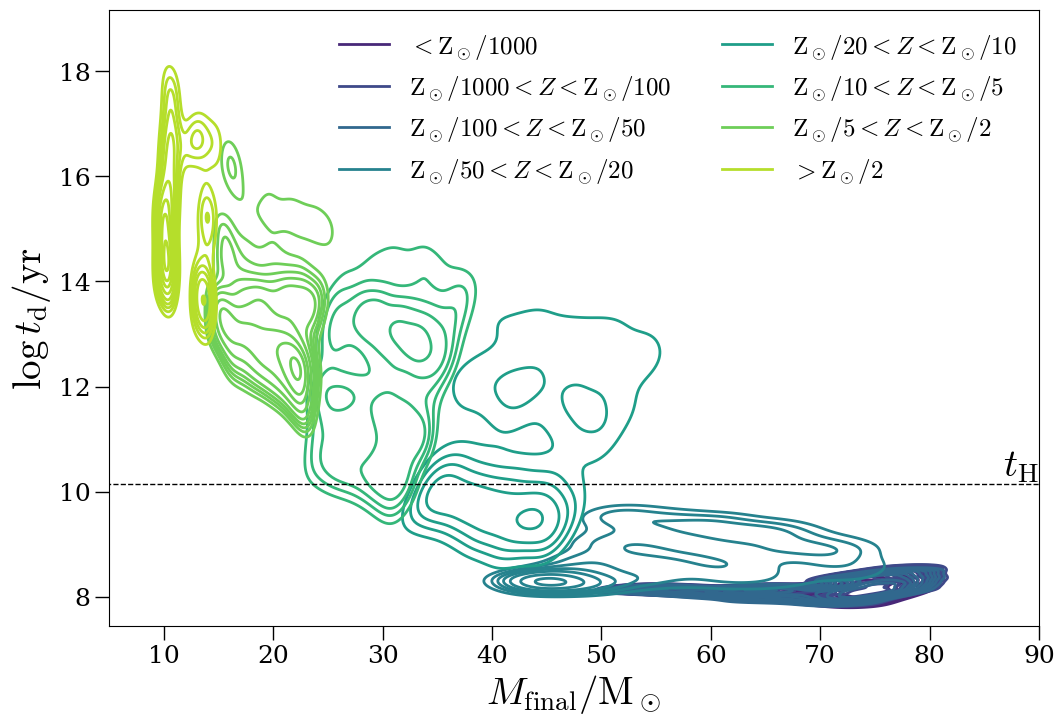

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))

kde = sns.kdeplot(data=df, x='m_final_msun', y='log_td_yr', hue='Metallicity range', fill=False, thresh=0, levels=20, palette='viridis', ax=ax, hue_order=list(met_ranges.values()))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, fontsize=18, title='', ncol=2)
ax.set_xlabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_ylabel('$\log t_\mathrm{d}/\\mathrm{yr}$')
ax.hlines(np.log10(th), 0, 90, color='k', ls='--', lw=1)
ax.text(90, np.log10(th), '$t_\mathrm{H}$', color='k', ha='right', va='bottom')
ax.set_xlim(5, 90)

savefig(fig, 'mfinal_td_2dkde')

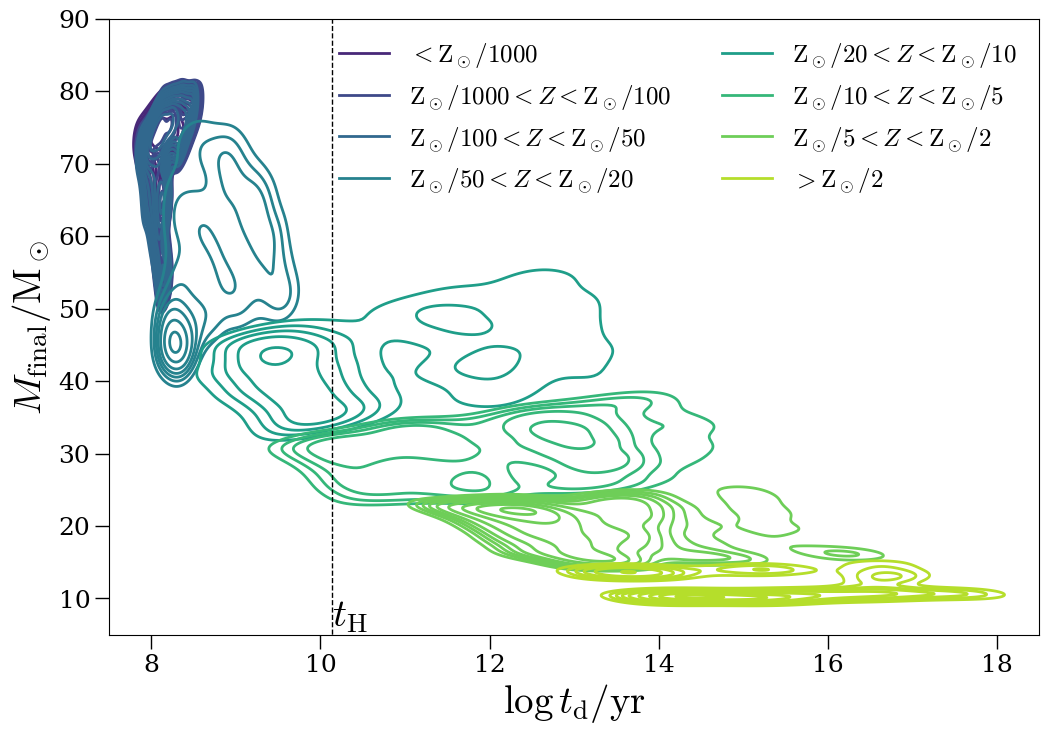

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

kde = sns.kdeplot(data=df, x='log_td_yr', y='m_final_msun', hue='Metallicity range', fill=False, thresh=0, levels=20, palette='viridis', ax=ax, hue_order=list(met_ranges.values()))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, fontsize=18, title='', ncol=2)
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_xlabel('$\log t_\mathrm{d}/\\mathrm{yr}$')
ax.vlines(np.log10(th), 0, 90, color='k', ls='--', lw=1)
ax.text(np.log10(th), 5, '$t_\mathrm{H}$', color='k', ha='left', va='bottom')
ax.set_ylim(5, 90)
ax.set_xlim(7.5, 18.5)

savefig(fig, 'td_mfinal_2dkde')

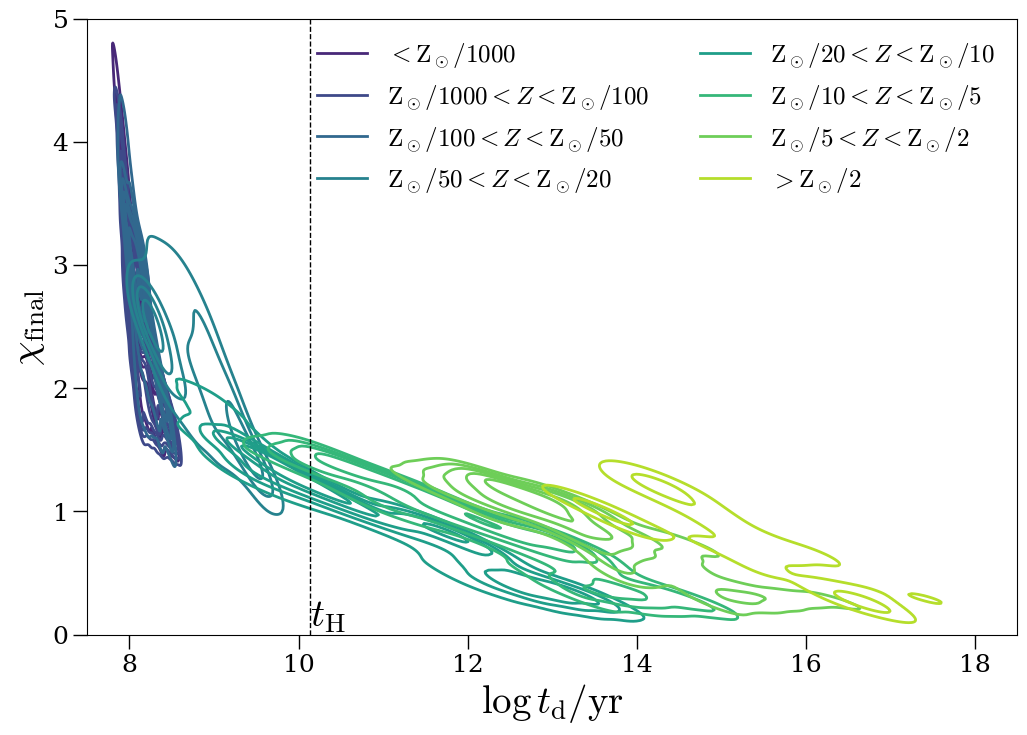

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))

kde = sns.kdeplot(data=df, x='log_td_yr', y='x_final', hue='Metallicity range', fill=False, thresh=0.05, levels=10, palette='viridis', ax=ax, hue_order=list(met_ranges.values()))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, fontsize=18, title='', ncol=2)
ax.set_ylabel('$\chi_\mathrm{final}$')
ax.set_xlabel('$\log t_\mathrm{d}/\\mathrm{yr}$')
ax.vlines(np.log10(th), 0, 5, color='k', ls='--', lw=1)
ax.text(np.log10(th), 0, '$t_\mathrm{H}$', color='k', ha='left', va='bottom')
ax.set_ylim(0, 5)
ax.set_xlim(7.5, 18.5)

savefig(fig, 'td_chifinal_2dkde')

In [75]:
fulldf = pd.DataFrame(
    sample, 
    columns=[
        'z_zsun',
        'm_zams_msun',            
        'p_zams_d',
        'r_zams_rsun',
        'm_final_msun',
        'x_final',
        'log_td_yr'
        ]
    )
fulldf.log_td_yr = np.log10(fulldf.log_td_yr)

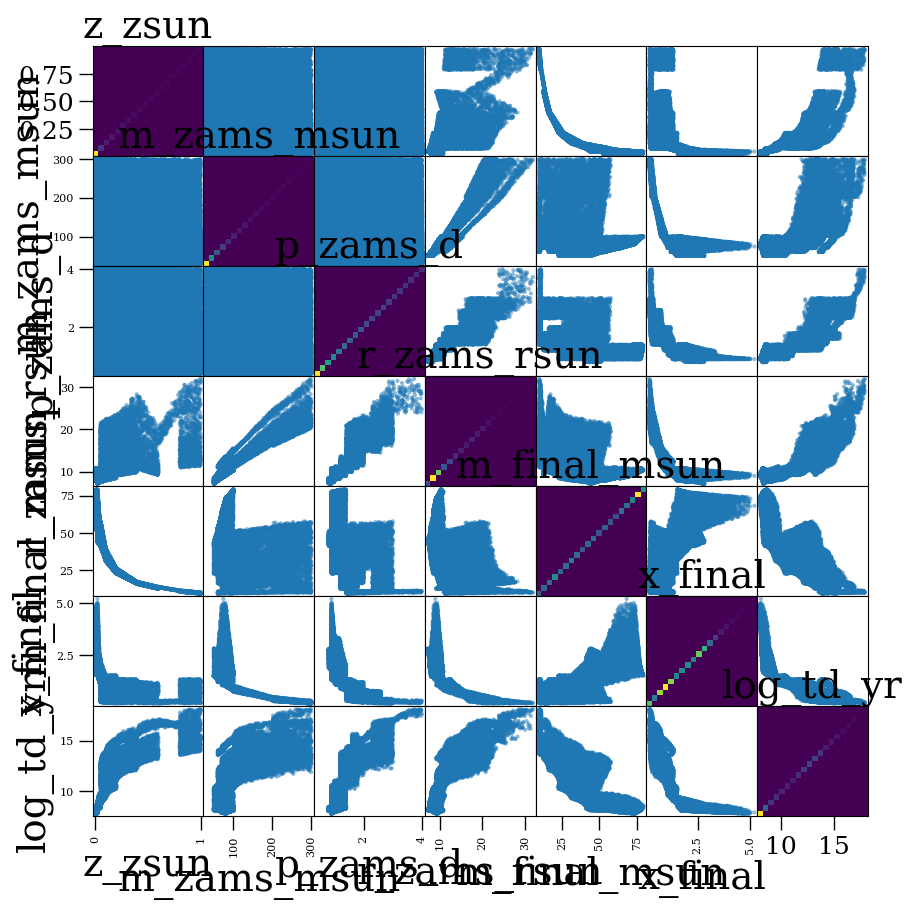

In [81]:
scatter_matrix = pd.plotting.scatter_matrix(fulldf, figsize=(10, 10))

# Replace histograms with 2D histograms
for i in range(fulldf.shape[1]):
    ax = scatter_matrix[i, i]
    ax.cla()  # Clear the default histogram
    valid_indices = ~fulldf.iloc[:, i].isna() & ~fulldf.iloc[:, i].isna()
    
    x = fulldf.iloc[:, i]
    x = x[valid_indices]
    y = fulldf.iloc[:, i]
    y = y[valid_indices]
    
    ax.hist2d(x, y, bins=20, cmap=plt.cm.viridis)  # Plot 2D histogram
    ax.set_title(fulldf.columns[i])

In [83]:
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   z_zsun        1000000 non-null  float64
 1   m_zams_msun   1000000 non-null  float64
 2   p_zams_d      1000000 non-null  float64
 3   r_zams_rsun   31574 non-null    float64
 4   m_final_msun  31574 non-null    float64
 5   x_final       31574 non-null    float64
 6   log_td_yr     31574 non-null    float64
dtypes: float64(7)
memory usage: 53.4 MB


(array([[9.201e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [0.000e+00, 2.183e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 1.338e+03, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.041e+03, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
    

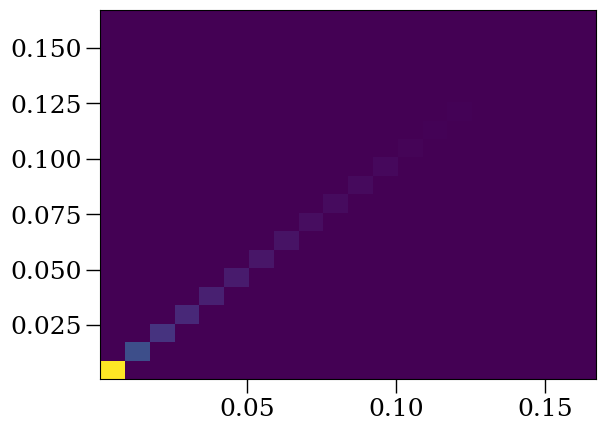

In [90]:
i = 0
j = 0

valid_indices = ~df.iloc[:, i].isna() & ~df.iloc[:, j].isna()
    
x = df.iloc[:, i]
x = x[valid_indices]
y = df.iloc[:, j]
y = y[valid_indices]

plt.hist2d(x, y, bins=20)

(array([10070.,  9920.,  9905., 10059.,  9964.,  9888.,  9959., 10134.,
         9971., 10041., 10052.,  9920.,  9978.,  9969., 10146.,  9991.,
         9955., 10064.,  9900., 10116.,  9859., 10094.,  9930., 10096.,
         9993., 10059., 10104.,  9874.,  9992.,  9954., 10020., 10156.,
        10005.,  9932., 10034., 10063.,  9906., 10150.,  9993.,  9876.,
        10018., 10041.,  9926., 10033., 10051.,  9918.,  9918., 10126.,
        10290., 10006., 10010., 10182.,  9760.,  9864.,  9868.,  9939.,
         9927.,  9650.,  9847.,  9915.,  9862., 10049., 10164.,  9999.,
         9957., 10058., 10200., 10030.,  9875.,  9945.,  9890., 10152.,
         9986., 10074., 10111.,  9970.,  9790.,  9819., 10019.,  9980.,
        10011., 10045.,  9893.,  9864., 10092.,  9947., 10030., 10020.,
         9965., 10134.,  9981., 10092., 10148., 10071., 10054., 10130.,
        10234.,  9897., 10192.,  9889.]),
 array([-3.30102864e+00, -3.26801839e+00, -3.23500815e+00, -3.20199790e+00,
        -3.1689876

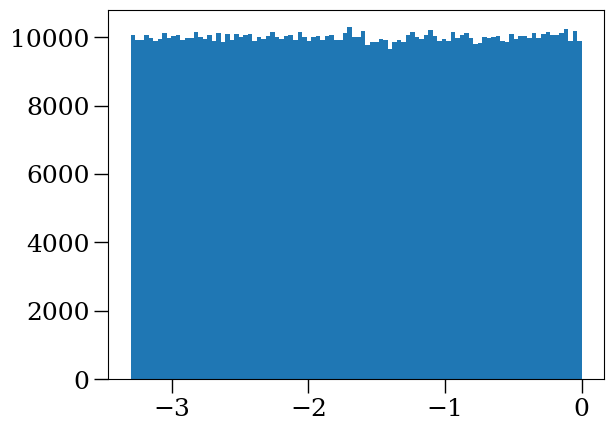

In [85]:
plt.hist(np.log10(sample[:, 0]), bins=100)

(array([2.310e+02, 1.950e+02, 2.280e+02, 1.884e+03, 2.148e+03, 2.108e+03,
        1.515e+03, 1.283e+03, 1.299e+03, 1.240e+03, 1.225e+03, 1.117e+03,
        1.066e+03, 1.074e+03, 1.013e+03, 1.006e+03, 1.000e+03, 9.940e+02,
        8.640e+02, 4.680e+02, 5.020e+02, 4.740e+02, 5.130e+02, 4.740e+02,
        4.870e+02, 5.000e+02, 4.910e+02, 4.970e+02, 4.850e+02, 4.980e+02,
        4.450e+02, 3.050e+02, 2.630e+02, 2.360e+02, 2.640e+02, 2.600e+02,
        2.420e+02, 1.600e+02, 6.100e+01, 6.900e+01, 6.400e+01, 7.200e+01,
        5.900e+01, 5.400e+01, 4.600e+01, 6.500e+01, 5.900e+01, 1.020e+02,
        1.000e+02, 1.030e+02, 1.130e+02, 9.700e+01, 1.110e+02, 9.300e+01,
        1.040e+02, 9.700e+01, 8.500e+01, 7.900e+01, 7.400e+01, 6.700e+01,
        6.800e+01, 9.400e+01, 6.700e+01, 6.300e+01, 7.000e+01, 5.400e+01,
        7.200e+01, 6.700e+01, 5.900e+01, 7.000e+00, 3.000e+00, 2.000e+00,
        4.000e+00, 5.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 5.000e+00,
        8.000e+00, 6.000e+00, 4.000e+0

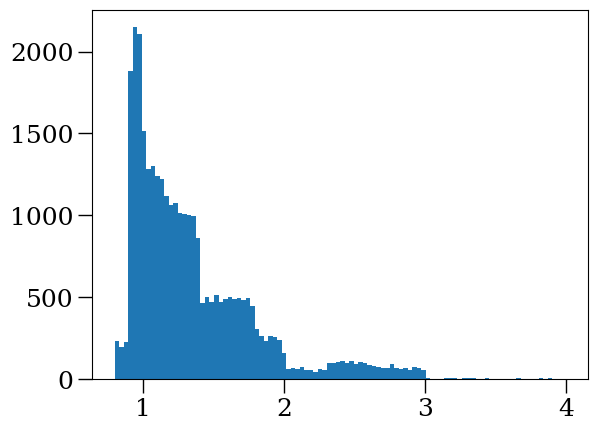

In [86]:
plt.hist(msample[:, 2], bins=100)

(array([[3.874e+03, 5.964e+03, 3.573e+03, 1.789e+03, 1.100e+01, 1.000e+01,
         6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [4.860e+02, 9.240e+02, 6.800e+02, 6.210e+02, 6.840e+02, 6.250e+02,
         2.060e+02, 1.160e+02, 1.040e+02, 1.140e+02, 1.090e+02, 9.100e+01,
         7.900e+01, 6.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [1.860e+02, 3.440e+02, 2.980e+02, 4.110e+02, 4.770e+02, 3.810e+02,
         3.440e+02, 1.840e+02, 5.800e+01, 5.700e+01, 5.500e+01, 6.400e+01,
         4.800e+01, 2.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [1.400e+02, 2.130e+02, 2.150e+02, 2.840e+02, 3.520e+02, 2.780e+02,
         2.230e+02, 1.200e+02, 3.800e+01, 3.400e+01, 3.700e+01, 3.600e+01,
         2.900e+01, 2.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
    

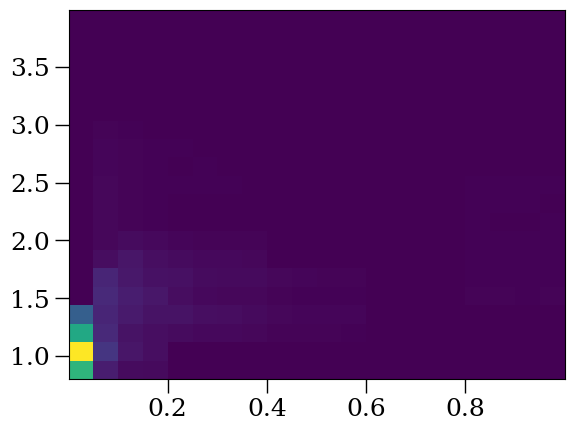

In [87]:
plt.hist2d(msample[:, 0], msample[:, 2], bins=20)

(array([[1.291e+03, 3.768e+03, 5.529e+03, 4.612e+03, 1.000e+00, 6.000e+00,
         2.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
         2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
         1.000e+00, 0.000e+00],
        [7.270e+02, 1.038e+03, 5.280e+02, 2.410e+02, 3.330e+02, 2.560e+02,
         1.660e+02, 1.420e+02, 1.250e+02, 1.060e+02, 7.100e+01, 7.300e+01,
         1.860e+02, 1.660e+02, 1.620e+02, 1.400e+02, 1.240e+02, 1.160e+02,
         9.700e+01, 1.020e+02],
        [3.950e+02, 3.500e+02, 3.220e+02, 2.670e+02, 2.730e+02, 1.760e+02,
         1.780e+02, 1.290e+02, 9.000e+01, 8.400e+01, 6.700e+01, 6.100e+01,
         8.800e+01, 6.800e+01, 8.700e+01, 7.700e+01, 6.600e+01, 6.400e+01,
         5.100e+01, 3.900e+01],
        [2.790e+02, 2.280e+02, 2.100e+02, 2.320e+02, 1.800e+02, 1.500e+02,
         9.100e+01, 8.400e+01, 6.900e+01, 5.700e+01, 3.700e+01, 4.400e+01,
         6.900e+01, 6.100e+01, 4.500e+01, 4.300e+01, 4.900e+01, 3.000e+01,
    

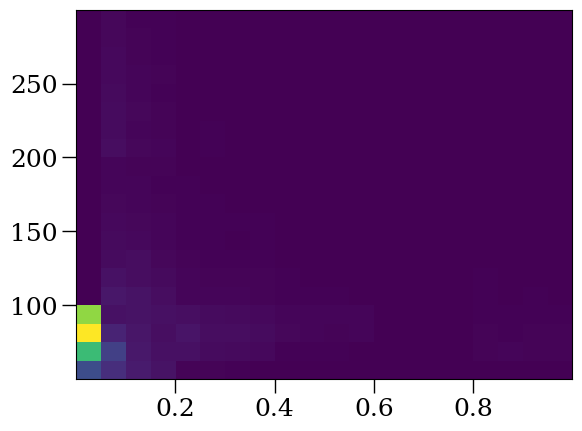

In [88]:
plt.hist2d(msample[:, 0], msample[:, 1], bins=20)

(array([[1.710e+03, 8.580e+02, 1.850e+02, 1.000e+02, 3.400e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [1.577e+03, 2.554e+03, 1.305e+03, 6.330e+02, 2.440e+02, 3.500e+01,
         3.000e+01, 1.800e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [8.490e+02, 2.391e+03, 2.173e+03, 1.691e+03, 5.050e+02, 1.850e+02,
         8.500e+01, 2.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [5.500e+02, 1.642e+03, 1.832e+03, 1.612e+03, 4.510e+02, 2.140e+02,
         7.800e+01, 2.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
    

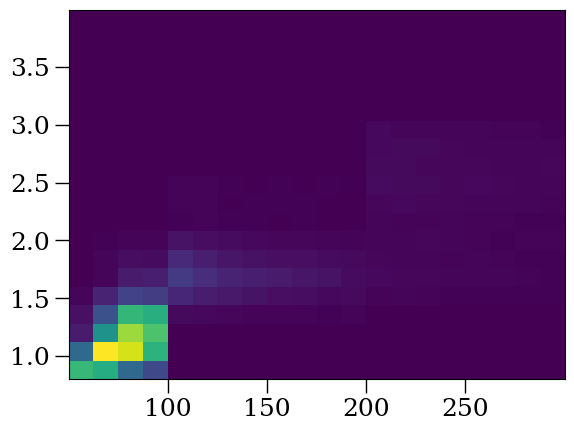

In [89]:
plt.hist2d(msample[:, 1], msample[:, 2], bins=20)

(array([2.310e+02, 1.950e+02, 2.280e+02, 1.884e+03, 2.148e+03, 2.108e+03,
        1.515e+03, 1.283e+03, 1.299e+03, 1.240e+03, 1.225e+03, 1.117e+03,
        1.066e+03, 1.074e+03, 1.013e+03, 1.006e+03, 1.000e+03, 9.940e+02,
        8.640e+02, 4.680e+02, 5.020e+02, 4.740e+02, 5.130e+02, 4.740e+02,
        4.870e+02, 5.000e+02, 4.910e+02, 4.970e+02, 4.850e+02, 4.980e+02,
        4.450e+02, 3.050e+02, 2.630e+02, 2.360e+02, 2.640e+02, 2.600e+02,
        2.420e+02, 1.600e+02, 6.100e+01, 6.900e+01, 6.400e+01, 7.200e+01,
        5.900e+01, 5.400e+01, 4.600e+01, 6.500e+01, 5.900e+01, 1.020e+02,
        1.000e+02, 1.030e+02, 1.130e+02, 9.700e+01, 1.110e+02, 9.300e+01,
        1.040e+02, 9.700e+01, 8.500e+01, 7.900e+01, 7.400e+01, 6.700e+01,
        6.800e+01, 9.400e+01, 6.700e+01, 6.300e+01, 7.000e+01, 5.400e+01,
        7.200e+01, 6.700e+01, 5.900e+01, 7.000e+00, 3.000e+00, 2.000e+00,
        4.000e+00, 5.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 5.000e+00,
        8.000e+00, 6.000e+00, 4.000e+0

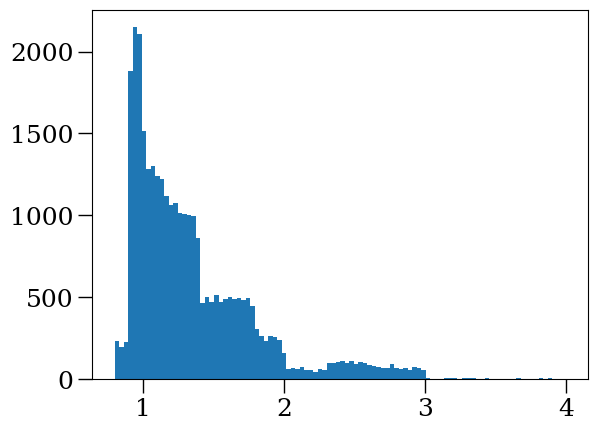

In [90]:
plt.hist(msample[:, 2], bins=100)

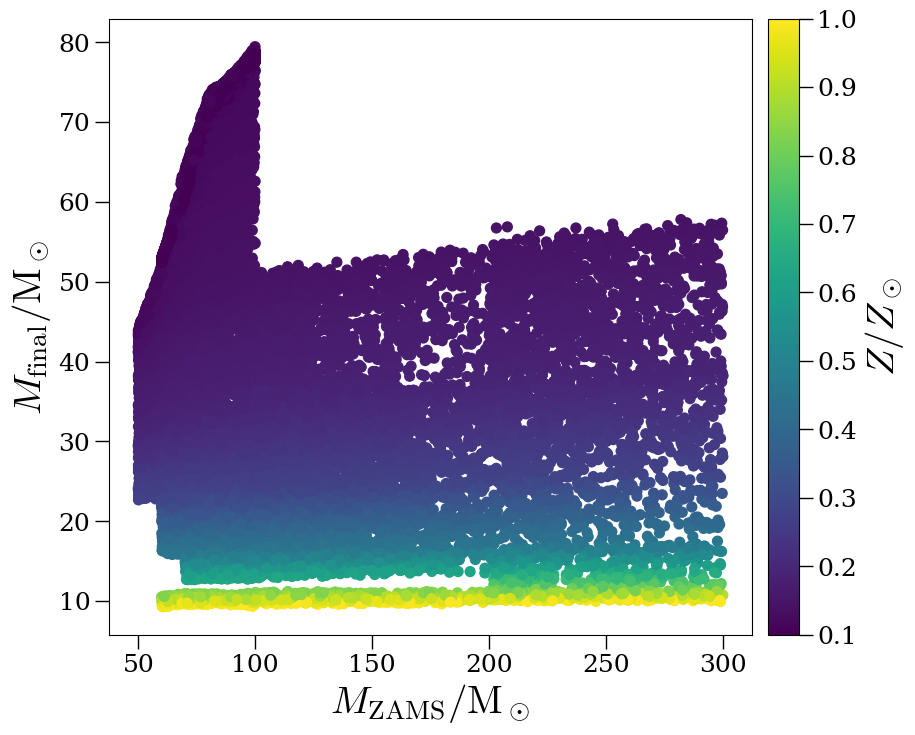

In [91]:
x = msample[:, 1]
y = msample[:, 4]
c = msample[:, 0]

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x, y, c=c, s=50)
ax.set_xlabel('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=0.1, vmax=1.0))
cb = fig.colorbar(sm, ax=ax, location='right', pad=0.02) 
cb.set_label('$Z/Z_\odot$')

#ax.set_yscale('log')
#ax.set_xscale('log')

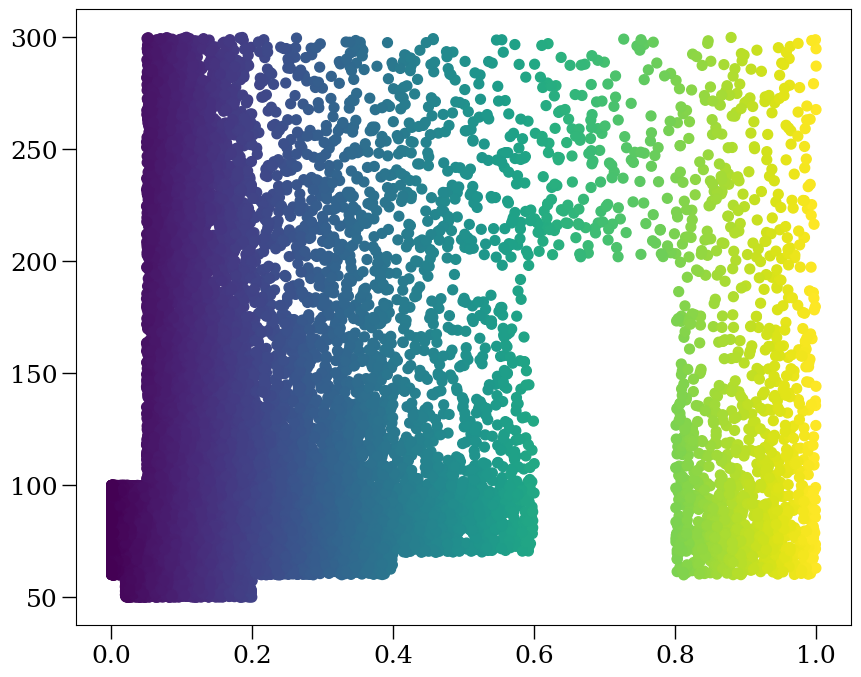

In [92]:
x = msample[:, 0]
y = msample[:, 1]
c = msample[:, 0]

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x, y, c=c, s=50)
#ax.set_yscale('log')
#ax.set_xscale('log')

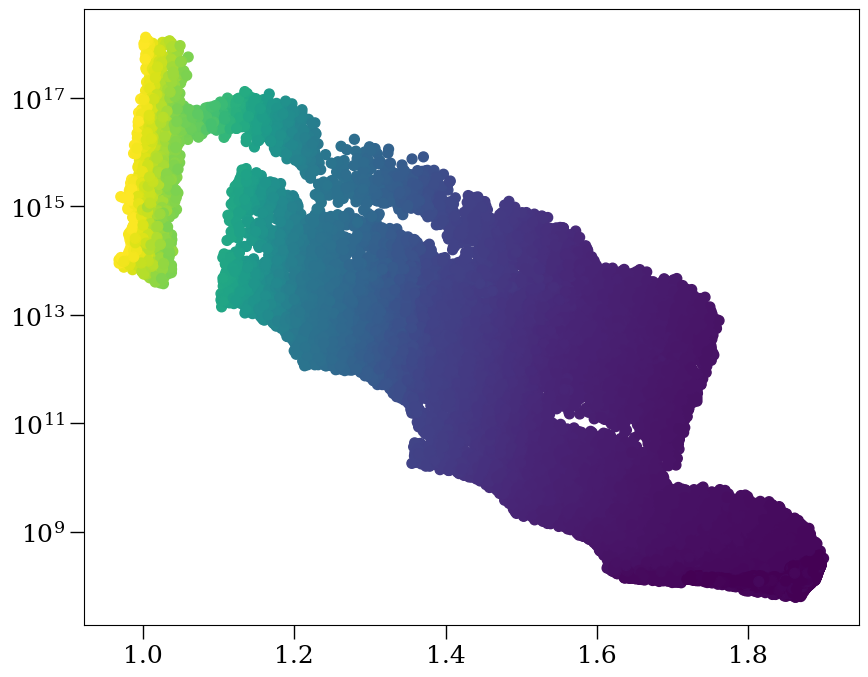

In [93]:
x = sample[:, 4]
y = sample[:, 6]
c = sample[:, 0]

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(np.log10(x), y, c=c, s=50)
ax.set_yscale('log')